Notebook to analyse the relation of the amount of SBP adoption in each municipality in each year with the various features, only for the municipalities and years which saw adoption.

2nd step of the double hurdle model.

## Content
* Data ingestion
* Data first exploration
* Features analysis
    * Variance analysis
    * Correlation
        * (Test for normality)
        * Spearman rho
            * Correlation matrices
        * Correlation analysis restricted to PCF years
        * Elimination based on correlation score
        * Test census features combinations 
* Multicollinearity analysis (VIF)
    * With census features combined and not

In [1]:
import pandas as pd
import os

In [2]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Version 2 split pre-PCF: only municipalities PCF (if any), proportionally to the pasture area

In [3]:
path_to_final_dataset = "Municipalities final dataset for analysis.csv"

# Data ingestion

In [4]:
dataset_original = pd.read_csv(path_to_final_dataset, index_col=['Municipality', 'Year'])

### Restrict to the municipalities and years with non-null adoption 

In [5]:
mask_no_adoption = dataset_original['adoption_in_year'] < 0.0000001
dataset_original = dataset_original.drop(dataset_original.loc[mask_no_adoption].index)
len(dataset_original)

2259

In [6]:
dataset = dataset_original.reset_index(drop=True)

In [7]:
dataset.head(2)

,adoption_in_year,adoption_pr_y_munic,tot_cumul_adoption_pr_y_munic,cumul_adoption_10_y_pr_y_munic,adoption_pr_y_neighbours_adj,tot_cumul_adoption_pr_y_neighbours_adj,cumul_adoption_10_y_pr_y_neighbours_adj,adoption_pr_y_neighbours_10km,tot_cumul_adoption_pr_y_neighbours_10km,cumul_adoption_10_y_pr_y_neighbours_10km,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
0,0.059690,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.9375,685.084722,289.652778,68.951389,11.578111,15.373729,1.327431,6.903449,5.697485,0.0
1,0.032558,0.05969,0.05969,0.05969,0.002899,0.002899,0.002899,0.004177,0.004177,0.004177,...,0.9375,685.084722,289.652778,68.951389,11.578111,15.373729,1.327431,6.903449,5.697485,0.0


In [8]:
dataset.columns

Index(['adoption_in_year', 'adoption_pr_y_munic',
       'tot_cumul_adoption_pr_y_munic', 'cumul_adoption_10_y_pr_y_munic',
       'adoption_pr_y_neighbours_adj',
       'tot_cumul_adoption_pr_y_neighbours_adj',
       'cumul_adoption_10_y_pr_y_neighbours_adj',
       'adoption_pr_y_neighbours_10km',
       'tot_cumul_adoption_pr_y_neighbours_10km',
       'cumul_adoption_10_y_pr_y_neighbours_10km',
       'adoption_pr_y_neighbours_20km',
       'tot_cumul_adoption_pr_y_neighbours_20km',
       'cumul_adoption_10_y_pr_y_neighbours_20km',
       'adoption_pr_y_neighbours_40km',
       'tot_cumul_adoption_pr_y_neighbours_40km',
       'cumul_adoption_10_y_pr_y_neighbours_40km',
       'adoption_pr_y_neighbours_60km',
       'tot_cumul_adoption_pr_y_neighbours_60km',
       'cumul_adoption_10_y_pr_y_neighbours_60km',
       'adoption_pr_y_neighbours_80km',
       'tot_cumul_adoption_pr_y_neighbours_80km',
       'cumul_adoption_10_y_pr_y_neighbours_80km', 'adoption_pr_y_port',
       'tot

## Organise features by categorical/numerical and by topic

In [9]:
label = ['adoption_in_year']

In [10]:
features_list = [col for col in dataset.columns if col != 'adoption_in_year']
features = pd.DataFrame(index=dataset.columns, columns=['num/cat', 'topic'])

In [11]:
adoption_features = [feat for feat in features.index if 'adoption' in feat and feat not in label]
features.loc[adoption_features, :] = ['num', 'SBP_adoption']

In [12]:
climate_features = [feat for feat in features.index if '_t_' in feat or '_prec_' in feat]
features.loc[climate_features, :] = ['num', 'climate']

In [13]:
soil_features = ['CaCO3_mean_munic', 'CN_mean_munic', 'N_mean_munic', 'P_mean_munic', 'pH_mean_munic']
features.loc[soil_features, :] = ['num', 'soil']

In [14]:
economic_features = ['sbp_payment']
features.loc[economic_features, :] = ['num', 'economic']

In [15]:
features_not_census = adoption_features + climate_features + soil_features + economic_features 
census_features = [feat for feat in features_list if feat not in features_not_census]
features.loc[census_features, :] = ['num', 'census']

# First exploration

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2259 entries, 0 to 2258
Data columns (total 78 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   adoption_in_year                          2259 non-null   float64
 1   adoption_pr_y_munic                       2259 non-null   float64
 2   tot_cumul_adoption_pr_y_munic             2259 non-null   float64
 3   cumul_adoption_10_y_pr_y_munic            2259 non-null   float64
 4   adoption_pr_y_neighbours_adj              2259 non-null   float64
 5   tot_cumul_adoption_pr_y_neighbours_adj    2259 non-null   float64
 6   cumul_adoption_10_y_pr_y_neighbours_adj   2259 non-null   float64
 7   adoption_pr_y_neighbours_10km             2259 non-null   float64
 8   tot_cumul_adoption_pr_y_neighbours_10km   2259 non-null   float64
 9   cumul_adoption_10_y_pr_y_neighbours_10km  2259 non-null   float64
 10  adoption_pr_y_neighbours_20km       

In [17]:
dataset.describe()

,adoption_in_year,adoption_pr_y_munic,tot_cumul_adoption_pr_y_munic,cumul_adoption_10_y_pr_y_munic,adoption_pr_y_neighbours_adj,tot_cumul_adoption_pr_y_neighbours_adj,cumul_adoption_10_y_pr_y_neighbours_adj,adoption_pr_y_neighbours_10km,tot_cumul_adoption_pr_y_neighbours_10km,cumul_adoption_10_y_pr_y_neighbours_10km,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
count,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,...,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000
mean,0.006715,0.005564,0.030522,0.028549,0.004588,0.026446,0.024803,0.004792,0.027614,0.025902,...,8.020800,803.911722,281.667577,60.971542,19.411751,14.178393,1.683223,16.930758,5.742557,13.109221
std,0.013123,0.011399,0.060448,0.053874,0.006134,0.040402,0.036196,0.006108,0.040885,0.036680,...,8.830350,248.366225,14.675322,12.546854,18.630598,2.375963,0.448591,6.553954,0.495302,40.541664
min,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.023148,482.106248,235.395833,29.520833,1.185276,10.109032,0.564628,5.923609,4.923223,0.000000
25%,0.001253,0.000753,0.002758,0.002758,0.000661,0.002027,0.002027,0.000761,0.002530,0.002530,...,0.925926,598.781013,275.500000,52.862444,6.243879,11.855956,1.398242,11.863932,5.273842,0.000000
50%,0.002697,0.002126,0.010985,0.010985,0.002185,0.009633,0.009620,0.002416,0.010111,0.010095,...,4.722222,761.146884,282.125000,60.132408,12.681254,14.414611,1.591663,16.693200,5.710434,0.000000
75%,0.007229,0.005628,0.031587,0.031217,0.006163,0.031587,0.031115,0.006600,0.033869,0.032968,...,11.385118,915.329157,294.479167,72.020833,28.204472,16.474956,2.057481,21.626450,6.096658,0.000000
max,0.211205,0.210121,0.666414,0.583776,0.042213,0.304183,0.248410,0.044413,0.285705,0.234104,...,38.416667,1573.570385,301.375000,83.458333,111.860993,19.019662,3.045757,35.972962,7.008673,153.260000


array([[<AxesSubplot:title={'center':'adoption_in_year'}>]], dtype=object)

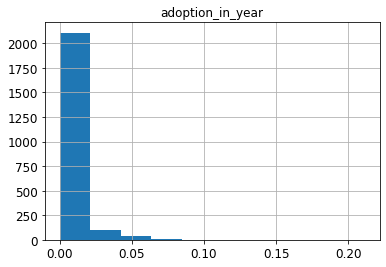

In [18]:
# Target variable distribution
dataset[label].hist()

In [19]:
adoption_features = features.loc[features['topic'] == 'SBP_adoption'].index.tolist()
#dataset[adoption_features].hist(figsize=(20, 20))

In [20]:
census_features = features.loc[(features['topic'] == 'census')].index.tolist()
#dataset[census_features].hist(figsize=(20, 20))

In [21]:
climate_features = features.loc[features['topic'] == 'climate'].index.tolist()
#dataset[climate_features].hist(figsize=(20, 20))

In [22]:
soil_features = features.loc[features['topic'] == 'soil'].index.tolist()
#dataset[soil_features].hist(figsize=(15, 8))

# Features analysis

## Variance analysis

In [23]:
var = (dataset.describe().loc['std'] / dataset.describe().loc['mean'])
var.sort_values(ascending=True)

prof_only_practical               0.045041
days_no_prec_average_munic        0.052102
individual_prod_autonomous        0.062792
av_d_mean_t_average_munic         0.082399
pH_mean_munic                     0.086251
                                    ...   
cumul_adoption_10_y_pr_y_munic    1.887099
adoption_in_year                  1.954330
tot_cumul_adoption_pr_y_munic     1.980477
adoption_pr_y_munic               2.048545
sbp_payment                       3.092607
Length: 78, dtype: float64

In [24]:
any(var < 0.01)

False

## Correlation analysis

In [25]:
features_num = features.loc[features['num/cat'] == 'num'].index.tolist()

#### Test for normality distribution the datasets' columns

In [26]:
from scipy.stats import kstest

results_ks = pd.DataFrame(index=features_num, columns=['statistic', 'p-value'])
for (columnName, columnData) in dataset.iteritems():
    stat, p = kstest(columnData, 'norm')
    results_ks.loc[columnName] = [stat, p]

In [27]:
(results_ks['p-value'] > 0.05).any()

False

### Spearman's correlation

In [28]:
from scipy.stats import spearmanr

def get_spearmanr_results(features):
    results = pd.DataFrame(index=features, columns=['spearman r'])

    for (columnName, columnData) in dataset[features].iteritems():
        coef, p = spearmanr(columnData, dataset['adoption_in_year'])
        results.loc[columnName] = coef
    return results

In [29]:
spearman_results = get_spearmanr_results(features_num)

In [30]:
spearman_results.loc[adoption_features, :].sort_values('spearman r', ascending=False)

,spearman r
cumul_adoption_10_y_pr_y_munic,0.702085
tot_cumul_adoption_pr_y_munic,0.701711
adoption_pr_y_munic,0.678448
tot_cumul_adoption_pr_y_neighbours_10km,0.618471
cumul_adoption_10_y_pr_y_neighbours_10km,0.617978
tot_cumul_adoption_pr_y_neighbours_20km,0.617221
cumul_adoption_10_y_pr_y_neighbours_20km,0.616426
tot_cumul_adoption_pr_y_neighbours_40km,0.614699
cumul_adoption_10_y_pr_y_neighbours_40km,0.614115
tot_cumul_adoption_pr_y_neighbours_60km,0.603911


While in the classification the previous year ones are all more important, here the distance seems actually the most important factor.

In [31]:
spearman_results.loc[census_features, :].sort_values('spearman r', ascending=False)

,spearman r
educ_basic_3rd_cycle,0.307437
educ_secondary_not_agr,0.292714
prof_complete,0.257202
educ_secondary_agr,0.253064
ext_imp_principal,0.250337
educ_polyt_or_superior_agr,0.24605
ext_sit_employed_by_others,0.221242
individual_prod_in_business,0.215118
ext_sit_self_employed,0.207692
pastures_mean_size_munic,0.205555


Note that the correlation for pastures_area_munic could be inflated by the fact that I split the adoption previous to 2008 proportionally to the permanent pasture area

In [32]:
spearman_results.loc[climate_features, :].sort_values('spearman r', ascending=False)

,spearman r
days_mean_t_over_20_pr_y_munic,0.388704
av_d_max_t_pr_y_munic,0.3781
days_max_t_over_30_pr_y_munic,0.3781
days_mean_t_over_20_average_munic,0.367638
av_d_mean_t_average_munic,0.341371
days_mean_t_over_25_average_munic,0.341366
days_mean_t_over_25_pr_y_munic,0.334837
av_d_min_t_average_munic,0.322488
cons_days_no_prec_average_munic,0.319645
days_no_prec_average_munic,0.30503


In [33]:
spearman_results.loc[soil_features, :].sort_values('spearman r', ascending=False)

,spearman r
pH_mean_munic,0.342957
CaCO3_mean_munic,0.248373
CN_mean_munic,-0.229774
P_mean_munic,-0.274743
N_mean_munic,-0.310297


In [34]:
economic_features = features.loc[(features['topic'] == 'economic')].index.tolist()
spearman_results.loc[economic_features, :].sort_values('spearman r', ascending=False)

,spearman r
sbp_payment,0.292288


here instead positive!

#### Corrrelation matrix to spot also relation among the features

In [35]:
corr_matrix_sp = dataset.corr(method='spearman').round(decimals=2)

In [36]:
def plot_correlation_heatmap(matrix, size=(20, 20)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)
    im.set_clim(-1, 1)
    ax.grid(False)
    ax.xaxis.set(ticks=range(len(matrix.index)), ticklabels=matrix.index)
    plt.xticks(rotation=90)
    ax.yaxis.set(ticks=range(len(matrix.columns)), ticklabels=matrix.columns)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            ax.text(j, i, matrix.iloc[i, j], ha='center', va='center',
                    color='r')
    cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
    plt.show()

In [37]:
climate_features_average = [feat for feat in climate_features if 'average' in feat]

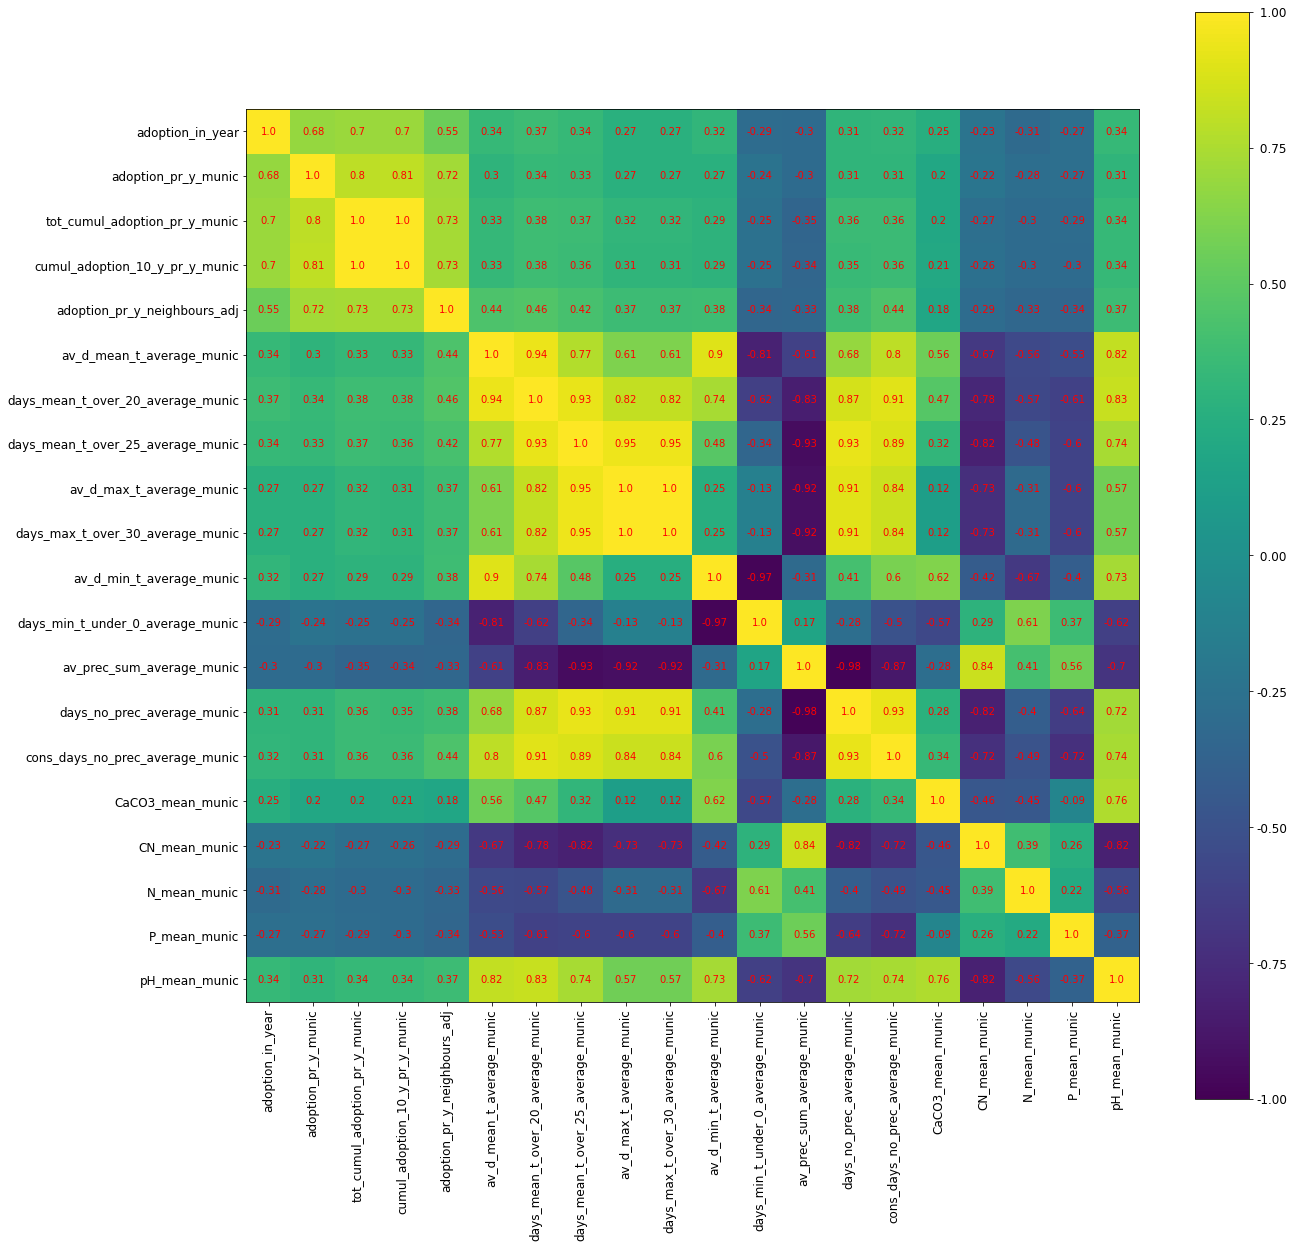

In [38]:
features_to_show = label + adoption_features[:4] + climate_features_average + soil_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show])

Correlation on adoption

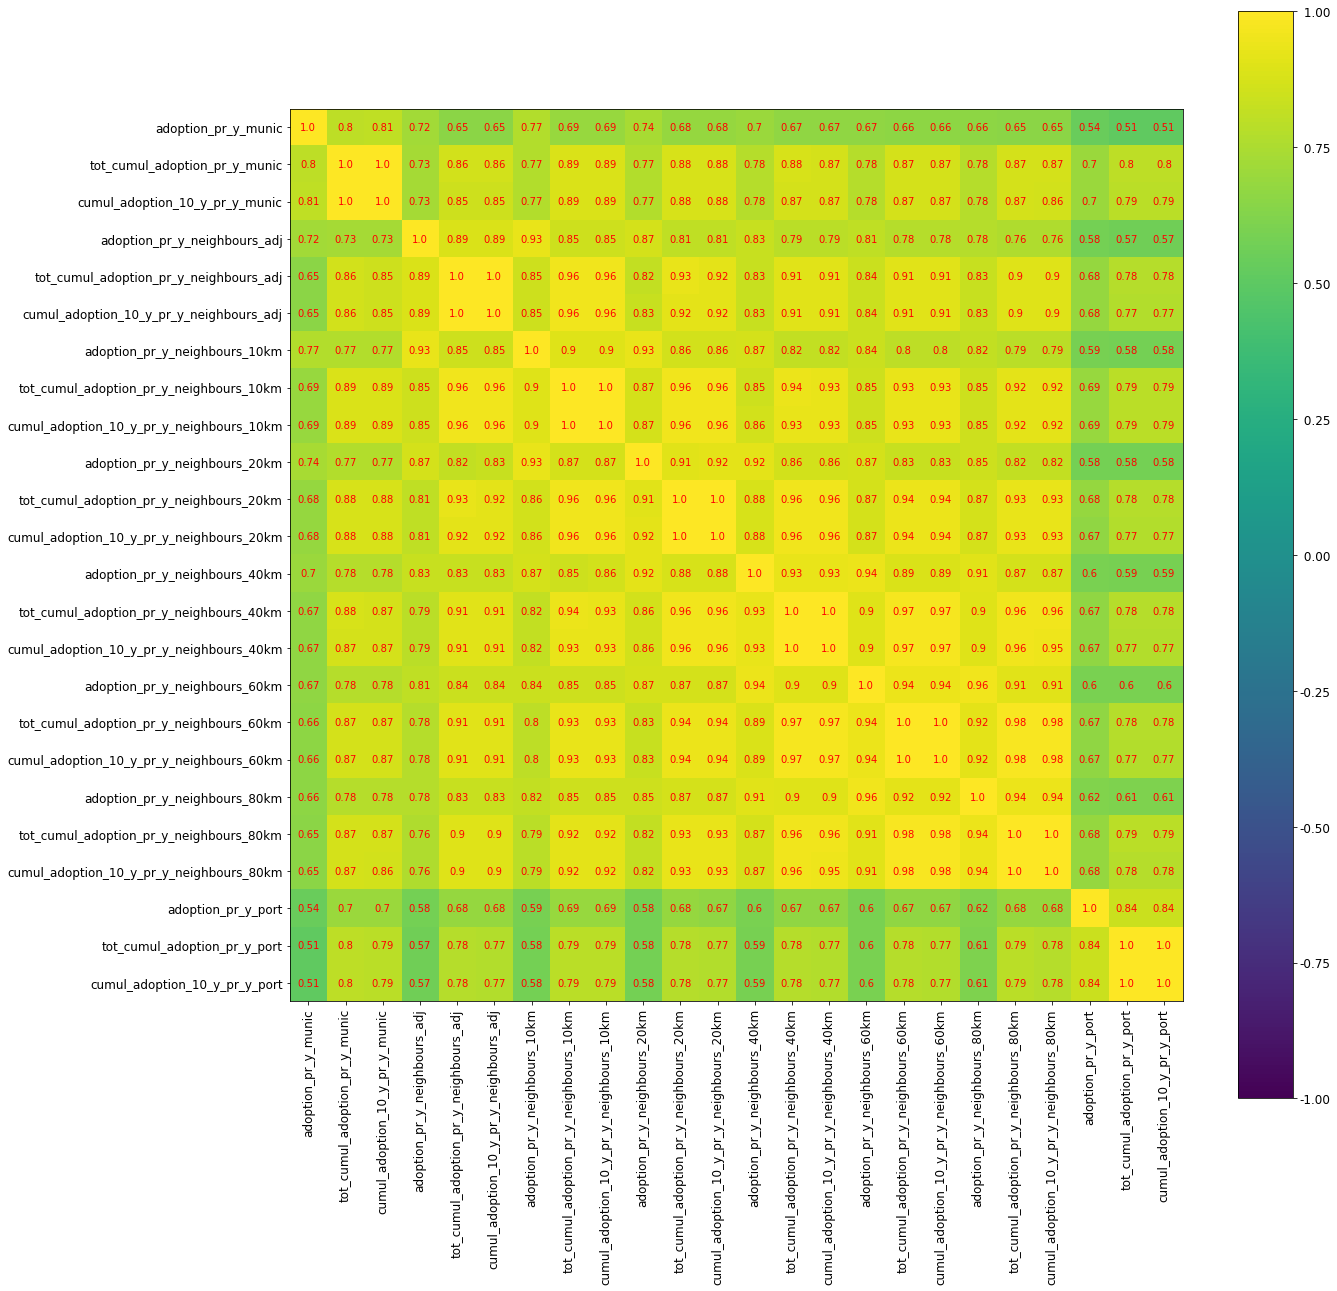

In [39]:
features_to_show = adoption_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show])

Correlation on census features

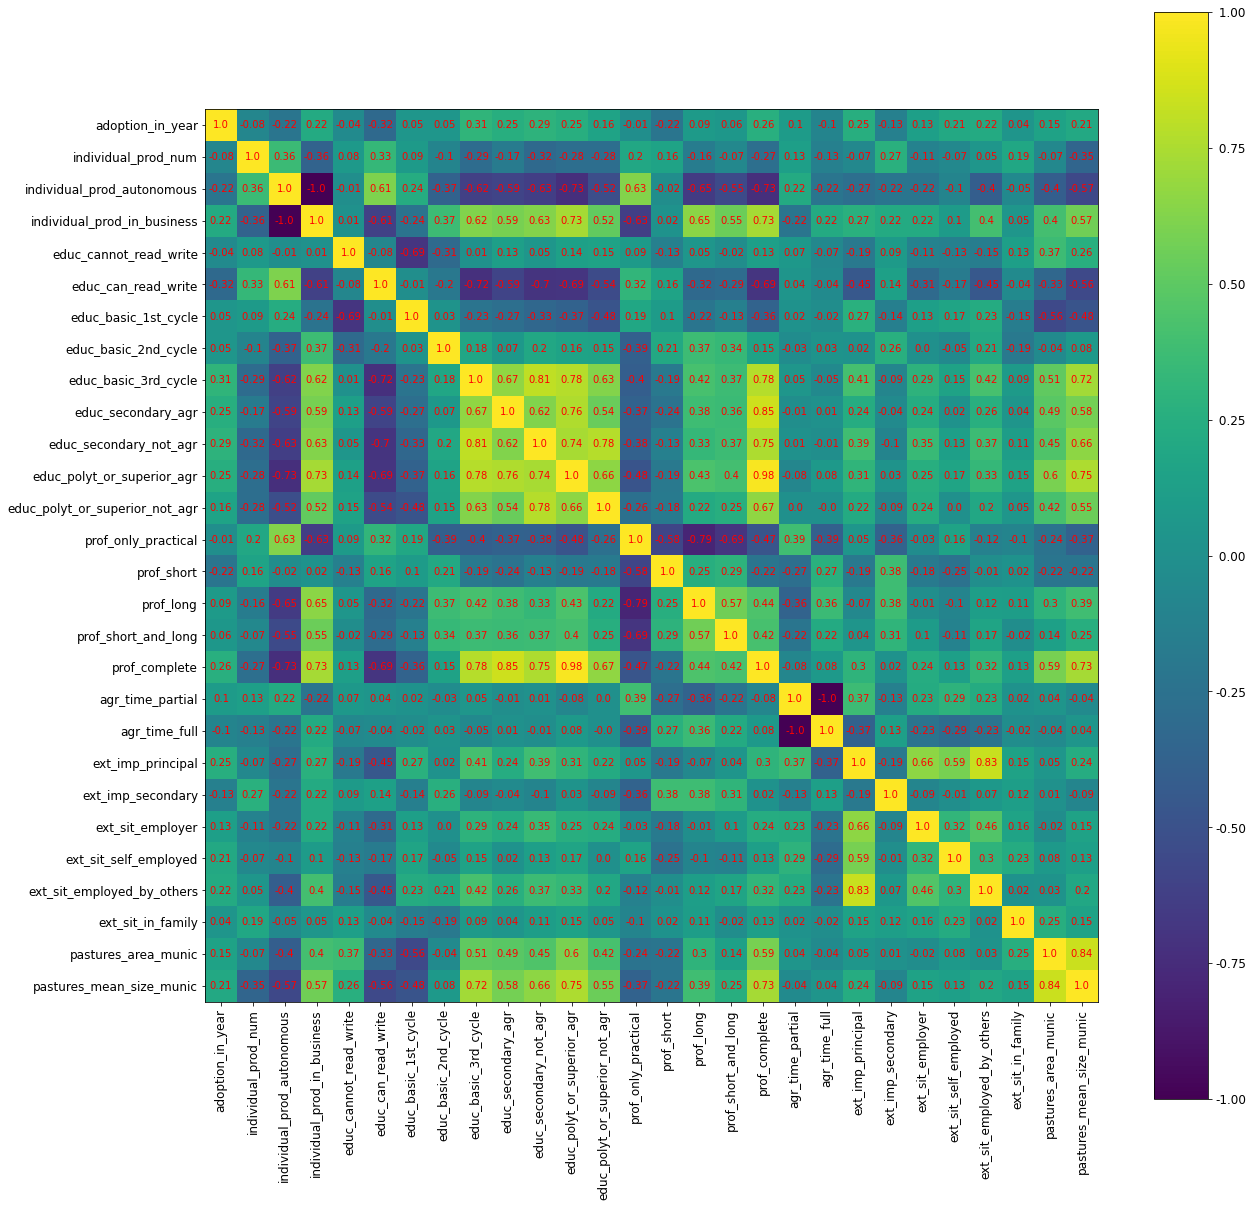

In [40]:
features_to_show = label + census_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show], size=(20, 20))

Correlation on environmental data

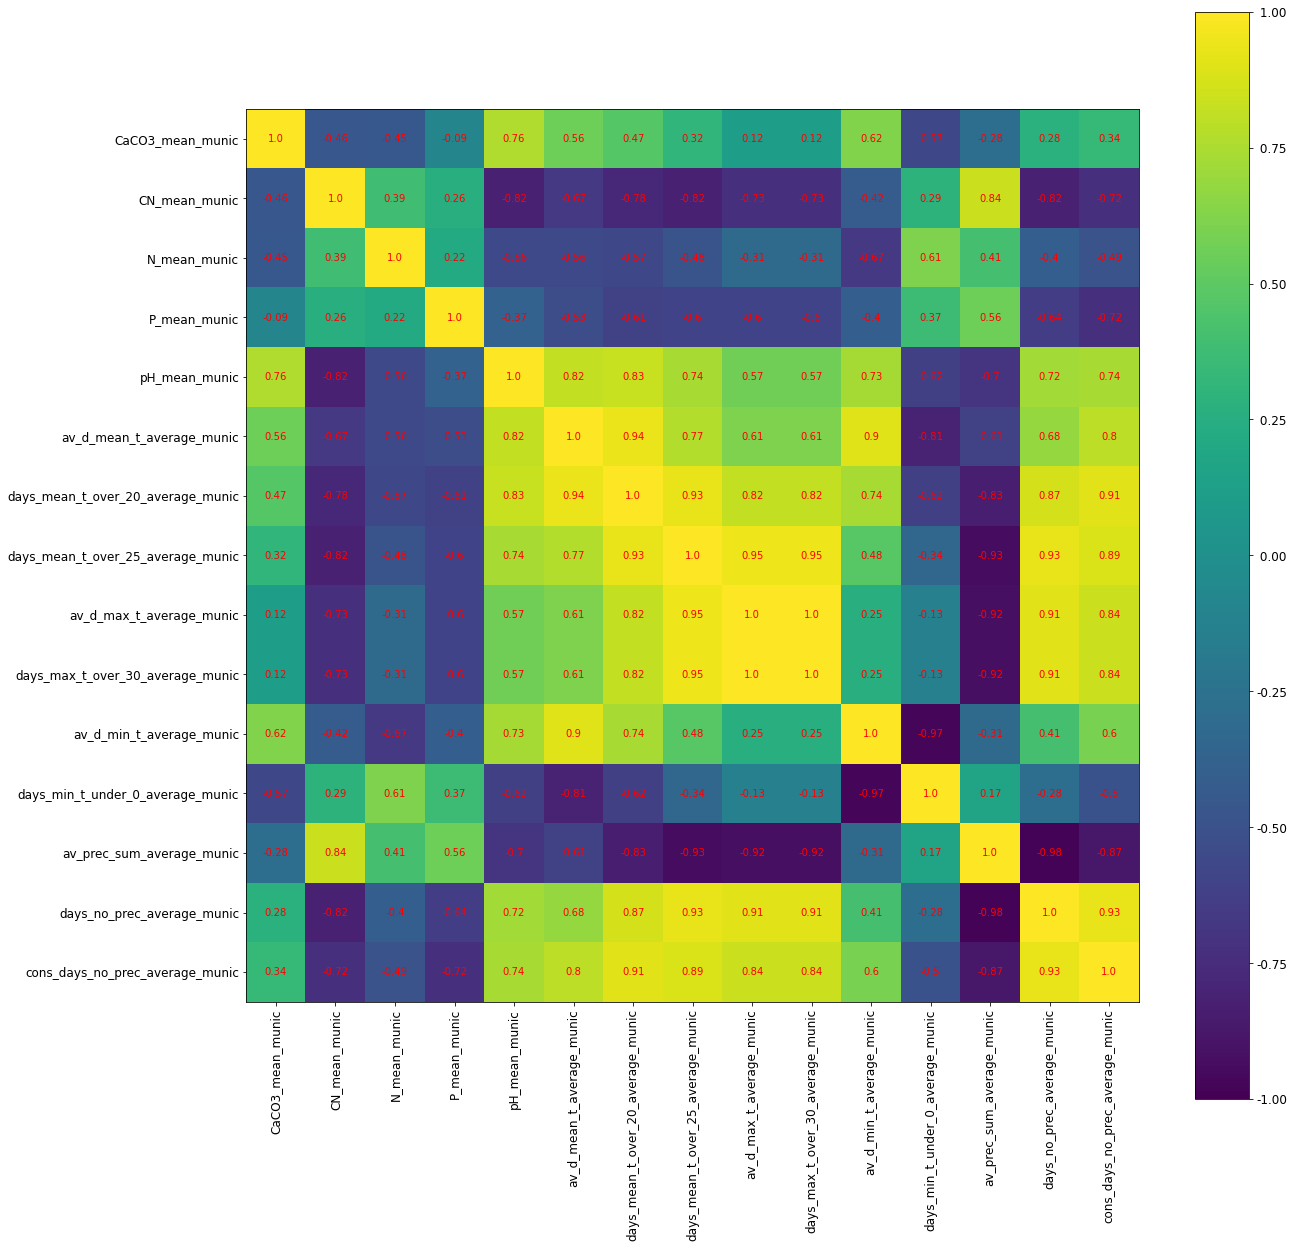

In [41]:
features_to_show = soil_features + climate_features_average
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show], size=(20, 20))

# First exploration with only years during the PCF project

In [42]:
dataset_PCF = dataset_original.loc[(slice(None), [2009, 2010, 2011, 2012]), :]

In [43]:
dataset_PCF = dataset_PCF.reset_index(drop=True)

In [44]:
len(dataset_PCF)

215

In [45]:
dataset_PCF.describe()

,adoption_in_year,adoption_pr_y_munic,tot_cumul_adoption_pr_y_munic,cumul_adoption_10_y_pr_y_munic,adoption_pr_y_neighbours_adj,tot_cumul_adoption_pr_y_neighbours_adj,cumul_adoption_10_y_pr_y_neighbours_adj,adoption_pr_y_neighbours_10km,tot_cumul_adoption_pr_y_neighbours_10km,cumul_adoption_10_y_pr_y_neighbours_10km,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,...,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.020521,0.014315,0.107830,0.091055,0.010842,0.102198,0.087577,0.011038,0.103727,0.088586,...,5.253481,604.884654,293.736063,72.107535,21.412519,12.042966,1.495410,13.321593,6.080602,137.738279
std,0.030086,0.024957,0.109358,0.088865,0.007635,0.060717,0.051073,0.007454,0.056498,0.047281,...,7.240120,66.741083,4.814465,6.783808,17.245490,1.228891,0.217080,5.037952,0.326041,9.805906
min,0.000105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005773,0.005488,...,0.023148,482.106248,281.215433,54.841667,2.611715,10.109032,1.003787,6.605951,5.321032,127.030000
25%,0.003821,0.001221,0.041002,0.034100,0.004416,0.055829,0.049945,0.004792,0.060749,0.053545,...,0.346154,557.486108,291.277778,68.951389,8.455102,11.091329,1.388400,9.935428,5.883692,132.100000
50%,0.011861,0.006304,0.062715,0.055581,0.009840,0.088878,0.076514,0.010148,0.091184,0.079529,...,2.972222,598.781013,295.291667,73.125000,17.762774,11.820409,1.494594,12.218766,6.066668,137.960000
75%,0.022932,0.018039,0.116052,0.107272,0.016296,0.137936,0.116471,0.016381,0.142207,0.121017,...,7.055556,632.401420,296.797917,77.078704,30.167416,12.826265,1.635335,15.007509,6.219608,145.610000
max,0.211205,0.210121,0.603120,0.541290,0.041649,0.304183,0.248410,0.044413,0.285705,0.234104,...,33.766667,796.201121,301.375000,83.458333,111.860993,15.566330,2.187741,29.620306,7.008673,153.260000


In [46]:
from scipy.stats import spearmanr

spearman_results_PCF = pd.DataFrame(index=features_num, columns=['spearman r only PCF'])

for (columnName, columnData) in dataset_PCF[features_num].iteritems():
    coef, p = spearmanr(columnData, dataset_PCF['adoption_in_year'])
    spearman_results_PCF.loc[columnName] = coef

In [47]:
# Merge with spearman rho results with all to compare
spearman_results_both = pd.concat([spearman_results_PCF, spearman_results], axis=1)
spearman_results_both.head()

,spearman r only PCF,spearman r
adoption_pr_y_munic,0.381715,0.678448
tot_cumul_adoption_pr_y_munic,0.357728,0.701711
cumul_adoption_10_y_pr_y_munic,0.357521,0.702085
adoption_pr_y_neighbours_adj,0.146259,0.550649
tot_cumul_adoption_pr_y_neighbours_adj,0.24801,0.581186


In [48]:
spearman_results_both.loc[adoption_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
adoption_pr_y_munic,0.381715,0.678448
tot_cumul_adoption_pr_y_munic,0.357728,0.701711
cumul_adoption_10_y_pr_y_munic,0.357521,0.702085
tot_cumul_adoption_pr_y_neighbours_20km,0.319451,0.617221
cumul_adoption_10_y_pr_y_neighbours_20km,0.312392,0.616426
tot_cumul_adoption_pr_y_neighbours_40km,0.310286,0.614699
cumul_adoption_10_y_pr_y_neighbours_80km,0.308465,0.596812
tot_cumul_adoption_pr_y_neighbours_60km,0.30499,0.603911
tot_cumul_adoption_pr_y_neighbours_80km,0.300189,0.598255
cumul_adoption_10_y_pr_y_neighbours_60km,0.299049,0.60297


In [49]:
spearman_results_both.loc[census_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
educ_basic_3rd_cycle,0.447496,0.307437
educ_secondary_not_agr,0.426876,0.292714
ext_sit_employer,0.333473,0.133845
prof_complete,0.311682,0.257202
educ_polyt_or_superior_agr,0.300986,0.24605
educ_polyt_or_superior_not_agr,0.288311,0.159717
individual_prod_in_business,0.268933,0.215118
prof_long,0.22041,0.086527
educ_secondary_agr,0.219486,0.253064
pastures_mean_size_munic,0.189144,0.205555


* Education features are really important (scholastic education but also agricultural training).
* Then...

In [50]:
spearman_results_both.loc[climate_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
days_max_t_over_30_average_munic,0.220334,0.26996
av_d_max_t_average_munic,0.220334,0.26996
av_d_max_t_pr_y_munic,0.208331,0.3781
days_max_t_over_30_pr_y_munic,0.208331,0.3781
days_mean_t_over_25_average_munic,0.206645,0.341366
days_mean_t_over_25_pr_y_munic,0.190709,0.334837
av_d_min_t_pr_y_munic,0.0962738,0.234841
days_mean_t_over_20_average_munic,0.0913017,0.367638
av_d_mean_t_pr_y_munic,0.0901362,0.285177
days_mean_t_over_20_pr_y_munic,0.0782478,0.388704


Apparently, climate much less important than in the decision if to adopt or not

In [51]:
spearman_results_both.loc[soil_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
pH_mean_munic,0.364159,0.342957
P_mean_munic,0.190467,-0.274743
CaCO3_mean_munic,0.168306,0.248373
N_mean_munic,-0.181749,-0.310297
CN_mean_munic,-0.226113,-0.229774


In [52]:
spearman_results_both.loc[economic_features, :].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
sbp_payment,-0.0261567,0.292288


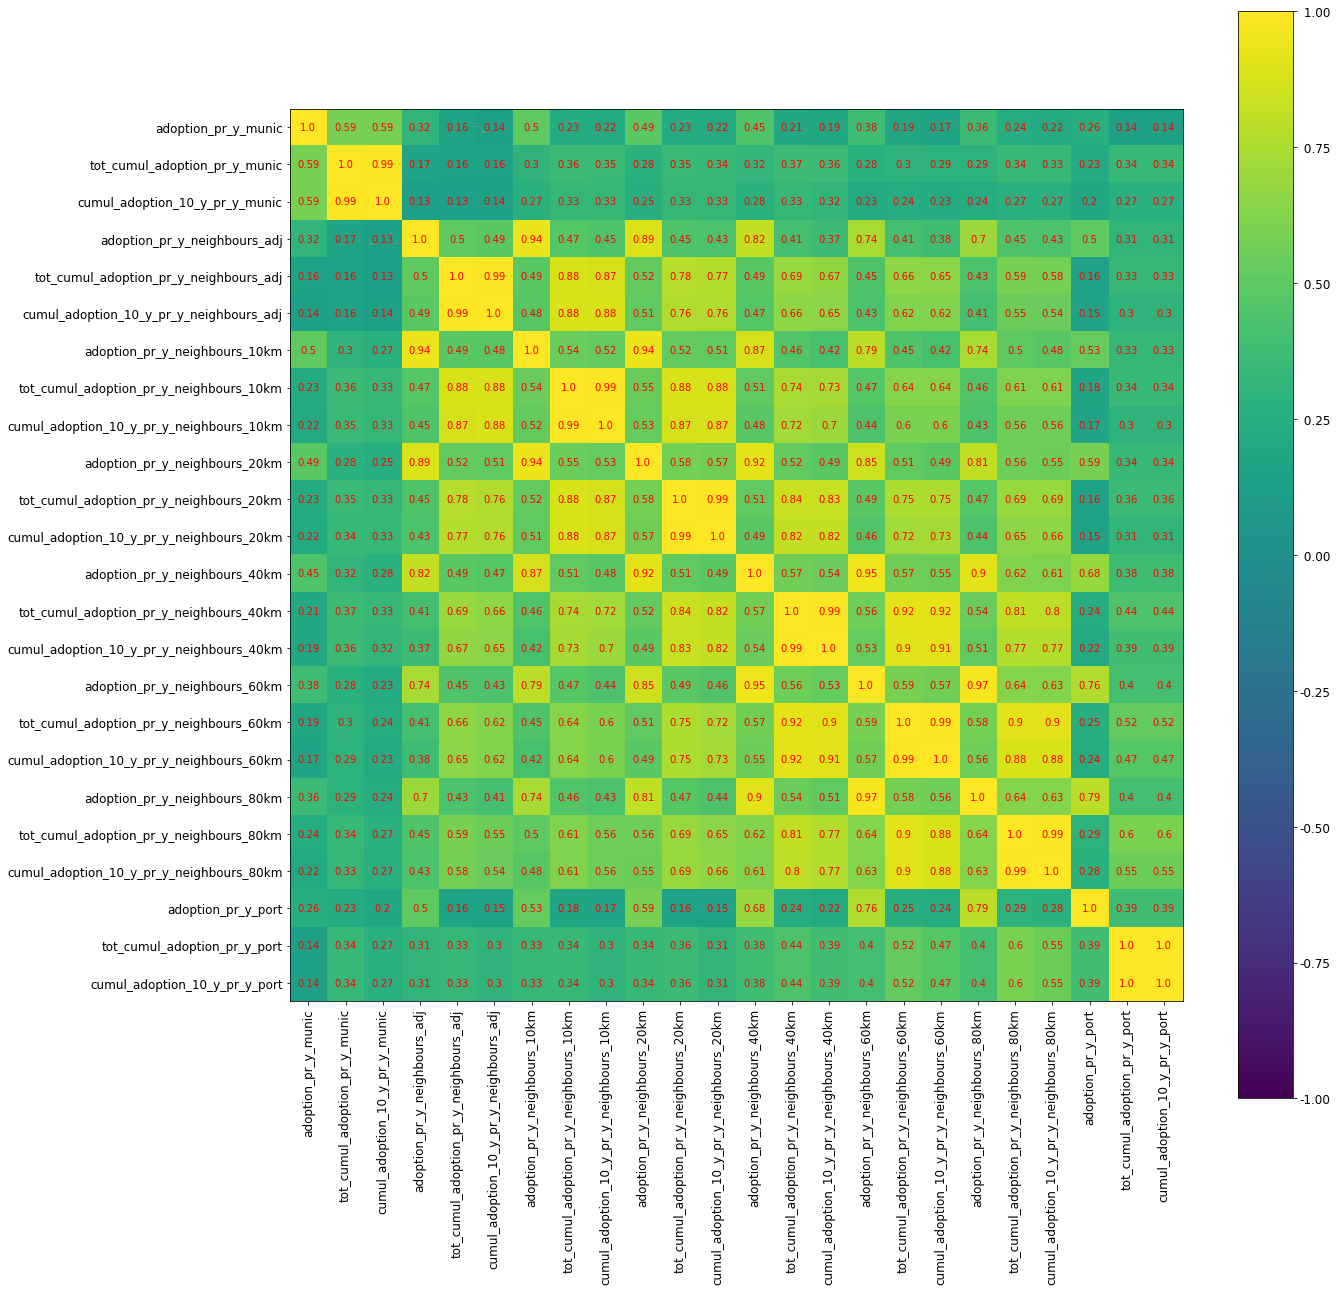

In [53]:
corr_matrix_sp = dataset_PCF.corr(method='spearman').round(decimals=2)
features_to_show = adoption_features
plot_correlation_heatmap(corr_matrix_sp.loc[features_to_show, features_to_show])

## Low correlations

In [54]:
sp_r_threshold = 0.1

In [55]:
mask_sp_r = (spearman_results_both['spearman r'] < sp_r_threshold) & (spearman_results_both['spearman r'] > -sp_r_threshold)
mask_sp_r_PCF = ((spearman_results_both['spearman r only PCF'] < sp_r_threshold)
                 & (spearman_results_both['spearman r only PCF'] > -sp_r_threshold))

low_sp_r = spearman_results_both.loc[mask_sp_r]
low_sp_r_PCF = spearman_results_both.loc[mask_sp_r_PCF]
low_sp_r_both = spearman_results_both.loc[mask_sp_r & mask_sp_r_PCF]

In [56]:
low_sp_r.sort_values('spearman r', ascending=True)

,spearman r only PCF,spearman r
agr_time_full,0.150267,-0.096844
individual_prod_num,-0.152782,-0.0815092
educ_cannot_read_write,-0.362732,-0.0417868
prof_only_practical,-0.316637,-0.00735458
ext_sit_in_family,0.0502792,0.0394726
educ_basic_2nd_cycle,0.137912,0.0514778
educ_basic_1st_cycle,0.12685,0.0519307
prof_short_and_long,0.154704,0.0637298
prof_long,0.22041,0.086527
agr_time_partial,-0.150267,0.096844


In [57]:
low_sp_r_PCF.sort_values('spearman r only PCF', ascending=True)

,spearman r only PCF,spearman r
days_no_prec_pr_y_munic,-0.0861816,0.244524
ext_imp_secondary,-0.07461,-0.131881
cons_days_no_prec_average_munic,-0.0682771,0.319645
days_min_t_under_0_pr_y_munic,-0.0628223,-0.138586
av_prec_sum_average_munic,-0.0530865,-0.296921
days_min_t_under_0_average_munic,-0.0471322,-0.288522
ext_sit_self_employed,-0.0374816,0.207692
sbp_payment,-0.0261567,0.292288
cumul_adoption_10_y_pr_y_port,-0.0204633,0.473616
tot_cumul_adoption_pr_y_port,-0.0204633,0.473616


In [58]:
low_sp_r_both

,spearman r only PCF,spearman r
ext_sit_in_family,0.0502792,0.0394726


In [59]:
spearman_results_both.loc['agr_time_full']

spearman r only PCF    0.150267
spearman r            -0.096844
Name: agr_time_full, dtype: object

### Adoption features combination

In [60]:
def get_spearman_both(features, d, d_PCF):
    if features=='all':
        features = d.columns
    results = pd.DataFrame(index=features, columns=['spearman r only PCF', 'spearman r'])
    
    for (columnName, columnData) in d[features].iteritems():
        coef, _ = spearmanr(columnData, d['adoption_in_year'])
        results.loc[columnName, 'spearman r'] = coef
        
    for (columnName, columnData) in d_PCF[features].iteritems():
        coef, _ = spearmanr(columnData, d_PCF['adoption_in_year'])
        results.loc[columnName, 'spearman r only PCF'] = coef

    return results

In [61]:
def add_to_dataset(dataset_original):
    dataset = dataset_original.copy()
    dataset['cumul_squared'] = dataset['cumul_adoption_10_y_pr_y_munic'] * dataset['cumul_adoption_10_y_pr_y_munic']
    return dataset

d = add_to_dataset(dataset)
d_PCF = add_to_dataset(dataset_PCF)

In [167]:
features = ['cumul_squared']
sp_res = get_spearman_both(features, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

KeyError: "None of [Index(['cumul_squared'], dtype='object')] are in the [columns]"

In [ ]:
d.plot(kind='scatter', x='cumul_squared', y='adoption_in_year')

### Census features combination

#### Education features

In [ ]:
educ_below_basica = ['educ_cannot_read_write', 'educ_can_read_write']

educ_above_basica = ['educ_secondary_agr', 'educ_secondary_not_agr',
                     'educ_polyt_or_superior_agr', 'educ_polyt_or_superior_not_agr']
educ_above_3rd_cycle = educ_above_basica + ['educ_basic_3rd_cycle']
educ_above_2nd_cycle = educ_above_3rd_cycle + ['educ_basic_2nd_cycle']
educ_above_1st_cycle = educ_above_2nd_cycle + ['educ_basic_1st_cycle']

def add_to_dataset(dataset_original):
    dataset = dataset_original.copy()
    dataset['educ_above_basic'] = dataset[educ_above_basica].sum(axis=1)
    dataset['educ_basic_3rd_cycle_or_higher'] = dataset[educ_above_3rd_cycle].sum(axis=1)
    dataset['educ_basic_2nd_cycle_or_higher'] = dataset[educ_above_2nd_cycle].sum(axis=1)
    dataset['educ_basic_1st_cycle_or_higher'] = dataset[educ_above_1st_cycle].sum(axis=1)

    dataset['ratio_high_over_low'] = dataset['educ_basic_3rd_cycle_or_higher'] / dataset[educ_below_basica].sum(axis=1)
    return dataset

In [ ]:
d = add_to_dataset(dataset)
d_PCF = add_to_dataset(dataset_PCF)

In [ ]:
features = (educ_above_1st_cycle + educ_below_basica +
            ['educ_above_basic', 'educ_basic_3rd_cycle_or_higher', 'educ_basic_2nd_cycle_or_higher', 
            'educ_basic_1st_cycle_or_higher', 'ratio_high_over_low'])
sp_res = get_spearman_both(features, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

#### Agricultural professional formation

In [168]:
prof_features_to_group = ['prof_long', 'prof_short_and_long', 'prof_complete']

def add_to_dataset(dataset_original):
    dataset = dataset_original.copy()
    dataset['prof_short_and_long_and_more'] = dataset[prof_features_to_group].sum(axis=1)
    
    return dataset

In [169]:
d = add_to_dataset(dataset)
d_PCF = add_to_dataset(dataset_PCF)

In [170]:
features = prof_features_to_group + ['prof_short', 'prof_only_practical'] + ['prof_short_and_long_and_more']
sp_res = get_spearman_both(features, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
prof_complete,0.311682,0.257202
prof_short_and_long_and_more,0.312367,0.153014
prof_long,0.22041,0.086527
prof_short_and_long,0.154704,0.0637298
prof_only_practical,-0.316637,-0.00735458
prof_short,0.0732709,-0.222403


#### External activities

In [171]:
ext_imp_features = ['ext_imp_principal', 'ext_imp_secondary']

def add_to_dataset(dataset):
    dataset = dataset_original.copy()
    dataset['ext_act_num'] = dataset[ext_imp_features].sum(axis=1) # Tried the total number of who has an external activity
    
    return dataset

In [172]:
d = add_to_dataset(dataset)
d_PCF = add_to_dataset(dataset_PCF)

In [173]:
features = ext_imp_features + ['ext_act_num']
sp_res = get_spearman_both(features, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
ext_imp_principal,0.250337,0.250337
ext_act_num,0.235515,0.235515
ext_imp_secondary,-0.131881,-0.131881


In [174]:
ext_sit_features_not_empl = ['ext_sit_self_employed', 'ext_sit_employed_by_others', 'ext_sit_in_family']

def add_to_dataset(dataset_original):
    dataset = dataset_original.copy()
    dataset['ext_sit_not_employer'] = dataset[ext_sit_features_not_empl].sum(axis=1)
    dataset['ext_sit_ratio_not_employer_to_employer'] = dataset['ext_sit_not_employer'] / dataset['ext_sit_employer']
    
    return dataset

In [175]:
d = add_to_dataset(dataset)
d_PCF = add_to_dataset(dataset_PCF)

In [176]:
features = ['ext_sit_employer'] + ext_sit_features_not_empl + ['ext_sit_not_employer', 
                                                                'ext_sit_ratio_not_employer_to_employer']
sp_res = get_spearman_both(features, d, d_PCF)
sp_res.sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
ext_sit_not_employer,0.11831,0.240694
ext_sit_employed_by_others,0.128733,0.221242
ext_sit_self_employed,-0.0374816,0.207692
ext_sit_employer,0.333473,0.133845
ext_sit_ratio_not_employer_to_employer,-0.286641,0.0620334
ext_sit_in_family,0.0502792,0.0394726


### Create transformer based on results of combination and correlations

In [177]:
from sklearn.base import BaseEstimator, TransformerMixin

In [178]:
class TransformCensusFeaturesCombCorr(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    If transform_census_features=False does not do anything. The other flags are to manage the single transformations.
    """
    def __init__(self, combine=True, keep_only_most_corr=False):
        self.combine = combine
        self.keep_only_most_corr = keep_only_most_corr

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # pastures_area_munic and mean_pastures_size_munic remain the same
        XX = X[['pastures_area_munic', 'pastures_mean_size_munic']]

        # individual_prod_num also kept
        XX = pd.concat([XX, X['individual_prod_num']], axis=1)

        # individual_prod_autonomous + individual_prod_in_business = 1 -> can keep only the second (opp. correlation)
        XX = pd.concat([XX, X['individual_prod_in_business']], axis=1)

        # 'agr_time_partial' + 'agr_time_full' = 1. But both have really low correlation --> exluded

        # external activity princ/sec: can just keep ext_imp_principal
        XX = pd.concat([XX, X['ext_imp_principal']], axis=1)

        if self.combine and self.keep_only_most_corr:
            raise ValueError("Only one among the parameters 'combine' and 'keep_only_most_relevant' can be True")

        elif self.combine:
            # Education: use ratio of high education over low
            feats_below_basic = ['educ_cannot_read_write', 'educ_can_read_write']
            feats_above_basic = ['educ_secondary_agr', 'educ_secondary_not_agr',
                                 'educ_polyt_or_superior_agr', 'educ_polyt_or_superior_not_agr']
            educ_below_basic = X[feats_below_basic].sum(axis=1)
            educ_above_basic = X[feats_above_basic].sum(axis=1)
            ratio = educ_above_basic / educ_below_basic
            ratio.name = 'educ_ratio_higher_lower'
            XX = pd.concat([XX, ratio], axis=1)

            # Agricultural professional formation: group short_and_long and above
            apf_feats_to_group = ['prof_long', 'prof_short_and_long', 'prof_complete']
            apf_grouped = X[apf_feats_to_group].sum(axis=1)
            apf_grouped.name = 'prof_above_some_long'
            XX = pd.concat([XX, apf_grouped], axis=1)

            # External activity situation: group not employed (employer has a low correlation)
            ext_sit_feats_not_empl = ['ext_sit_self_employed', 'ext_sit_employed_by_others', 'ext_sit_in_family']
            ext_sit_grouped = X[ext_sit_feats_not_empl].sum(axis=1)
            ext_sit_grouped.name = 'ext_sit_not_employer'
            XX = pd.concat([XX, ext_sit_grouped], axis=1)

        elif self.keep_only_most_corr:
            # Education
            educ_most_corr = 'educ_basic_3rd_cycle'
            XX = pd.concat([XX, X[educ_most_corr]], axis=1)     

            # Agricultural professional formation
            apf_most_corr = 'prof_complete'
            XX = pd.concat([XX, X[apf_most_corr]], axis=1)

            # External activity situation
            eas_most_corr = 'ext_sit_employed_by_others'
            XX = pd.concat([XX, X[eas_most_corr]], axis=1) 

        else:
            raise ValueError("One between the parameters 'combine' and 'keep_only_most_relevant' has to be True")

        return XX

In [179]:
dataset_census_attr_comb = TransformCensusFeaturesCombCorr(combine=True, keep_only_most_corr=False).transform(dataset)

In [180]:
census_features_comb = dataset_census_attr_comb.columns.to_list()

In [181]:
census_features_comb = dataset_census_attr_comb.columns.to_list()
dataset_comb_attr = dataset.drop(census_features, axis=1)
dataset_comb_attr = pd.concat([dataset_comb_attr, dataset_census_attr_comb], axis=1)

In [182]:
dataset_comb_attr.shape

(2259, 59)

In [183]:
dataset_census_attr_comb_PCF = TransformCensusFeaturesCombCorr(combine=True, keep_only_most_corr=False).transform(dataset_PCF)
dataset_comb_attr_PCF = dataset_PCF.drop(census_features, axis=1)
dataset_comb_attr_PCF = pd.concat([dataset_comb_attr_PCF, dataset_census_attr_comb_PCF], axis=1)

# Multicollinearity analysis (VIF)

**NOTE:** 
* dataset_comb_attr refers to the dataset in which the census features have been reduced combining them
* dataset_comb_attr_red refers to the dataset with attributes reduced based on correlation coefficients

Based on dataset including all years (unless not clear)

In [184]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [185]:
def vif(dataset):
    features = "+".join([feat for feat in dataset.columns if feat != "adoption_in_year"])
    y, X = dmatrices('adoption_in_year ~' + features, dataset, return_type='dataframe')
    with pd.option_context('mode.use_inf_as_null', True):
        X = X.dropna()

    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.set_index("features", inplace=True)
    return vif

In [186]:
vif_comb_attr = vif(dataset_comb_attr)

C:\Users\giaco\anaconda3\envs\data_analysis\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [187]:
vif_comb_attr.sort_values('VIF', ascending=False).head(10)

,VIF
features,
days_max_t_over_30_pr_y_munic,inf
av_d_max_t_pr_y_munic,inf
days_max_t_over_30_average_munic,inf
av_d_max_t_average_munic,inf
Intercept,9.400584e+04
tot_cumul_adoption_pr_y_neighbours_60km,2.866936e+03
tot_cumul_adoption_pr_y_neighbours_80km,2.797153e+03
cumul_adoption_10_y_pr_y_neighbours_60km,2.717758e+03
cumul_adoption_10_y_pr_y_neighbours_80km,2.604431e+03


## Custom transformers to reduce features and multicollinearity

Create a different transformer for each topic of features, trying to not have any VIF above 10

In [188]:
corr_matrix_comb_attr = dataset_comb_attr.corr(method='spearman').round(decimals=2)

In [189]:
sp_r_both_comb_attr = get_spearman_both('all', dataset_comb_attr, dataset_comb_attr_PCF)

#### Census features

In [190]:
vif_comb_attr.loc[census_features_comb]

,VIF
features,
pastures_area_munic,2.691539
pastures_mean_size_munic,4.961886
individual_prod_num,1.679528
individual_prod_in_business,3.545909
ext_imp_principal,11.291431
educ_ratio_higher_lower,3.664885
prof_above_some_long,4.534131
ext_sit_not_employer,10.897329


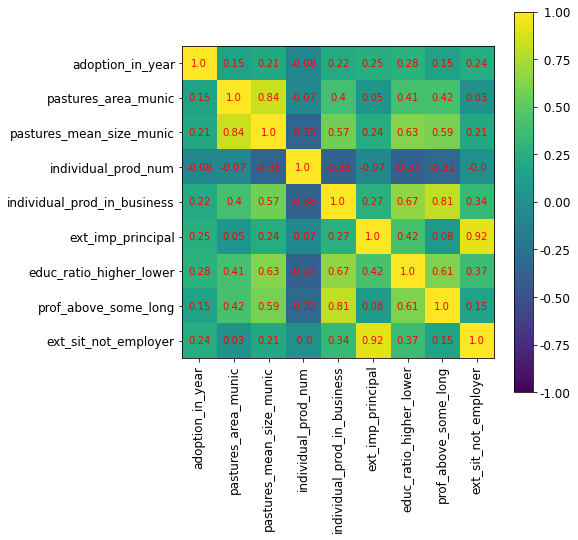

In [191]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + census_features_comb, label + census_features_comb], size=(7, 7))

In [192]:
sp_r_both_comb_attr.loc[['ext_imp_principal', 'ext_sit_not_employer']]

,spearman r only PCF,spearman r
ext_imp_principal,0.143634,0.250337
ext_sit_not_employer,0.11831,0.240694


Modification to TransformCensusFeaturesCombCorr: do not include ext_sit_not_employer

In [193]:
class TransformCensusFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, combine=True, keep_only_most_corr=False):
        self.combine = combine
        self.keep_only_most_corr = keep_only_most_corr

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # pastures_area_munic and mean_pastures_size_munic remain the same
        XX = X[['pastures_area_munic', 'pastures_mean_size_munic']]

        # individual_prod_num also kept
        XX = pd.concat([XX, X['individual_prod_num']], axis=1)

        # individual_prod_autonomous + individual_prod_in_business = 1 ->
        # can keep only the second (opp. correlation)
        XX = pd.concat([XX, X['individual_prod_in_business']], axis=1)

        # 'agr_time_partial' + 'agr_time_full' = 1. But both have really low 
        # correlation --> exluded
        
        # ext_imp_pricipal excluded since high correlation with 
        # ext_sit_not_employer/ext_sit_employed by others

        if self.combine and self.keep_only_most_corr:
            raise ValueError("Only one among the parameters 'combine' and"
                             "'keep_only_most_relevant' can be True")

        elif self.combine:
           # Education: group to have educ_3rd_cycle_or_higher
            feats_above_3rd_cycle = ['educ_basic_3rd_cycle',
                                     'educ_secondary_agr',
                                     'educ_secondary_not_agr',
                                     'educ_polyt_or_superior_agr',
                                     'educ_polyt_or_superior_not_agr']
            educ_above_basic = X[feats_above_3rd_cycle].sum(axis=1)
            educ_above_basic.name = 'educ_3rd_cycle_or_higher'
            XX = pd.concat([XX, educ_above_basic], axis=1)

            # Agricultural professional formation: group short_and_long and
            #above
            apf_feats_to_group = ['prof_long', 'prof_short_and_long',
                                  'prof_complete']
            apf_grouped = X[apf_feats_to_group].sum(axis=1)
            apf_grouped.name = 'prof_above_some_long'
            XX = pd.concat([XX, apf_grouped], axis=1)
            
            # External activity situation: group not employed (employer has a
            # low correlation)
            ext_sit_feats_not_empl = ['ext_sit_self_employed',
                                      'ext_sit_employed_by_others',
                                      'ext_sit_in_family']
            ext_sit_grouped = X[ext_sit_feats_not_empl].sum(axis=1)
            ext_sit_grouped.name = 'ext_sit_not_employer'
            XX = pd.concat([XX, ext_sit_grouped], axis=1)

        elif self.keep_only_most_corr:
            # Education
            educ_most_corr = 'educ_polyt_or_superior_agr'
            XX = pd.concat([XX, X[educ_most_corr]], axis=1)     

            # Agricultural professional formation
            apf_most_corr = 'prof_complete'
            XX = pd.concat([XX, X[apf_most_corr]], axis=1)

            # External activity situation
            eas_most_corr = 'ext_sit_employed_by_others'
            XX = pd.concat([XX, X[eas_most_corr]], axis=1)

        else:
            raise ValueError("One between the parameters 'combine' and"
                             "'keep_only_most_relevant' has to be True")

        return XX

#### Adoption features

In [194]:
adoption_features

['adoption_pr_y_munic',
 'tot_cumul_adoption_pr_y_munic',
 'cumul_adoption_10_y_pr_y_munic',
 'adoption_pr_y_neighbours_adj',
 'tot_cumul_adoption_pr_y_neighbours_adj',
 'cumul_adoption_10_y_pr_y_neighbours_adj',
 'adoption_pr_y_neighbours_10km',
 'tot_cumul_adoption_pr_y_neighbours_10km',
 'cumul_adoption_10_y_pr_y_neighbours_10km',
 'adoption_pr_y_neighbours_20km',
 'tot_cumul_adoption_pr_y_neighbours_20km',
 'cumul_adoption_10_y_pr_y_neighbours_20km',
 'adoption_pr_y_neighbours_40km',
 'tot_cumul_adoption_pr_y_neighbours_40km',
 'cumul_adoption_10_y_pr_y_neighbours_40km',
 'adoption_pr_y_neighbours_60km',
 'tot_cumul_adoption_pr_y_neighbours_60km',
 'cumul_adoption_10_y_pr_y_neighbours_60km',
 'adoption_pr_y_neighbours_80km',
 'tot_cumul_adoption_pr_y_neighbours_80km',
 'cumul_adoption_10_y_pr_y_neighbours_80km',
 'adoption_pr_y_port',
 'tot_cumul_adoption_pr_y_port',
 'cumul_adoption_10_y_pr_y_port']

In [195]:
vif_comb_attr.loc[adoption_features]

,VIF
features,
adoption_pr_y_munic,2.778197
tot_cumul_adoption_pr_y_munic,87.883107
cumul_adoption_10_y_pr_y_munic,88.455838
adoption_pr_y_neighbours_adj,14.451287
tot_cumul_adoption_pr_y_neighbours_adj,668.401762
cumul_adoption_10_y_pr_y_neighbours_adj,678.704413
adoption_pr_y_neighbours_10km,25.184984
tot_cumul_adoption_pr_y_neighbours_10km,1690.528724
cumul_adoption_10_y_pr_y_neighbours_10km,1646.164111


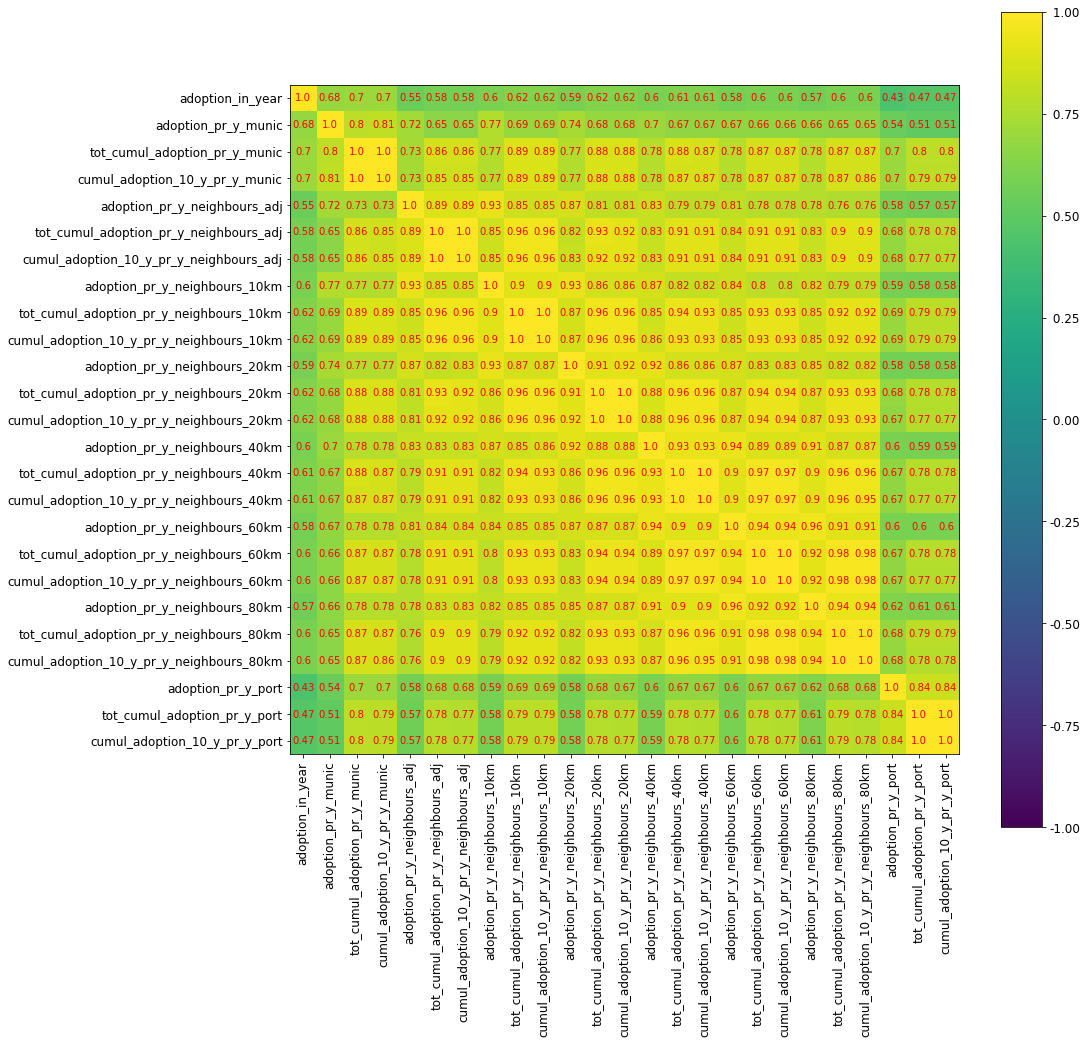

In [196]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + adoption_features, label + adoption_features], size=(15, 15))

In [197]:
sp_r_both_comb_attr.loc[adoption_features].sort_values('spearman r only PCF', ascending=False)

,spearman r only PCF,spearman r
adoption_pr_y_munic,0.381715,0.678448
tot_cumul_adoption_pr_y_munic,0.357728,0.701711
cumul_adoption_10_y_pr_y_munic,0.357521,0.702085
tot_cumul_adoption_pr_y_neighbours_20km,0.319451,0.617221
cumul_adoption_10_y_pr_y_neighbours_20km,0.312392,0.616426
tot_cumul_adoption_pr_y_neighbours_40km,0.310286,0.614699
cumul_adoption_10_y_pr_y_neighbours_80km,0.308465,0.596812
tot_cumul_adoption_pr_y_neighbours_60km,0.30499,0.603911
tot_cumul_adoption_pr_y_neighbours_80km,0.300189,0.598255
cumul_adoption_10_y_pr_y_neighbours_60km,0.299049,0.60297


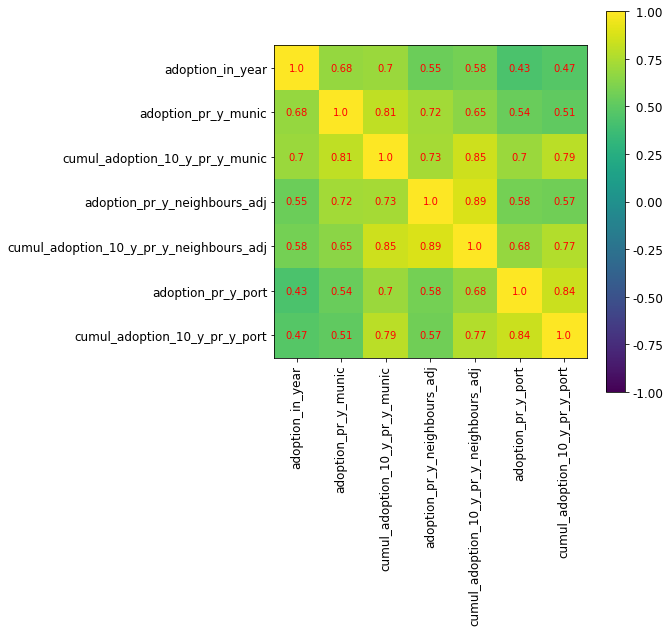

In [198]:
feats_munic = [feat for feat in adoption_features if '_munic' in feat]
feats_adj_neigh = [feat for feat in adoption_features if '_adj' in feat]
feats_port = [feat for feat in adoption_features if '_port' in feat]
feats_all = feats_munic + feats_adj_neigh + feats_port
feats = [feat for feat in feats_all if 'tot_cumul' not in feat]

plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + feats, label + feats], size=(7, 7))

In [352]:
class TransformAdoptionFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        adoption_features = X.columns
        # All features referring to cumul_10_y excluded    
        # Excluded everything for neighbouring not adjacent, since adoption in prev_year and cumul_10_y too correlated
        
        # Definition of the ones to keep: municipality, adjacent and portugal not tot_cumul       
        feats_munic = [feat for feat in adoption_features if '_munic' in feat]
        feats_adj_neigh = [feat for feat in adoption_features if '_adj' in feat]
        feats_port = [feat for feat in adoption_features if '_port' in feat]
        
        feats_to_keep_all = feats_munic + feats_adj_neigh + feats_port
        feats_to_keep = [feat for feat in feats_to_keep_all if '10_y' not in feat]
        
        return X[feats_to_keep]

#### Soil and climate features

In [353]:
env_features = soil_features + climate_features

In [354]:
prec_features = [feat for feat in climate_features if '_prec' in feat]

In [355]:
sp_r_both_comb_attr.loc[prec_features].sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
cons_days_no_prec_average_munic,-0.0682771,0.319645
days_no_prec_average_munic,-0.0181657,0.30503
days_no_prec_pr_y_munic,-0.0861816,0.244524
cons_days_no_prec_pr_y_munic,0.00537518,0.151505
av_prec_sum_pr_y_munic,0.0630588,-0.263176
av_prec_sum_average_munic,-0.0530865,-0.296921


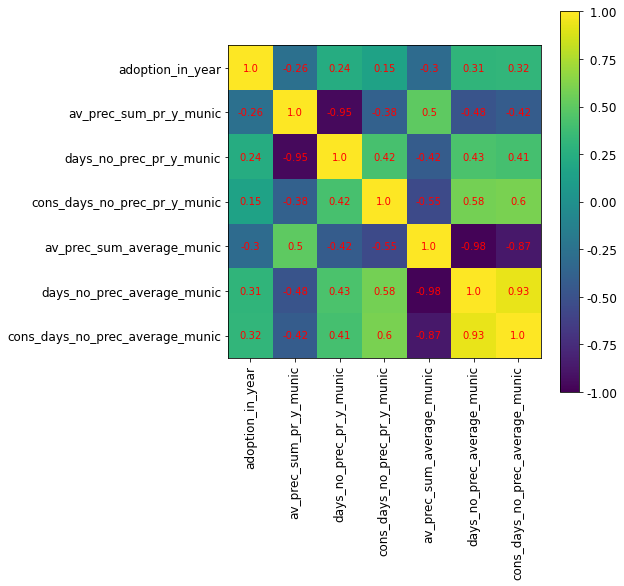

In [356]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + prec_features, label + prec_features], size=(7, 7))

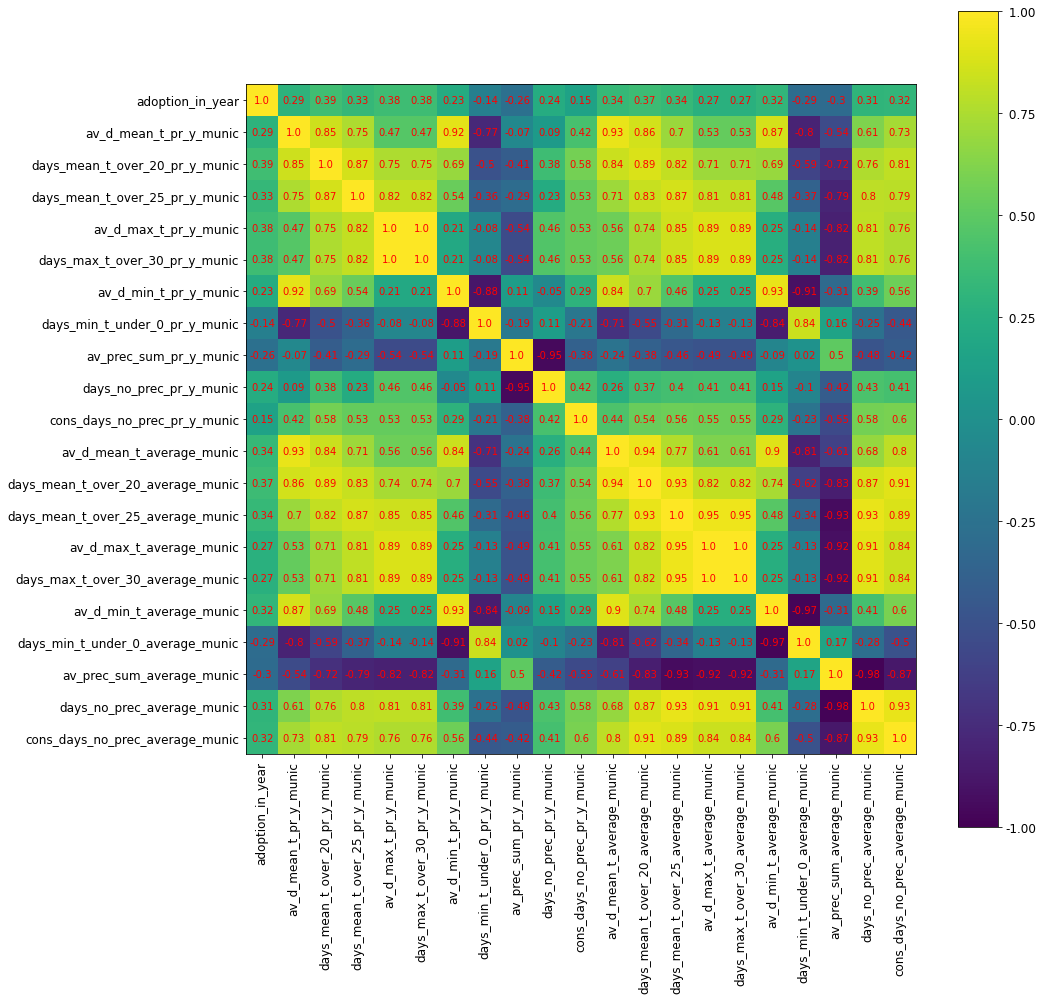

In [357]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + climate_features, label + climate_features], size=(15, 15))

In [358]:
feats_mean_t = [feat for feat in climate_features if 'av_d_mean_t' in feat]
feats_max_t = [feat for feat in climate_features if 'av_d_max_t' in feat]
feats_prec = [feat for feat in climate_features if 'cons_days_no_prec' in feat or 'av_prec_sum' in feat]
climate_features_kept = feats_mean_t + feats_max_t + feats_prec

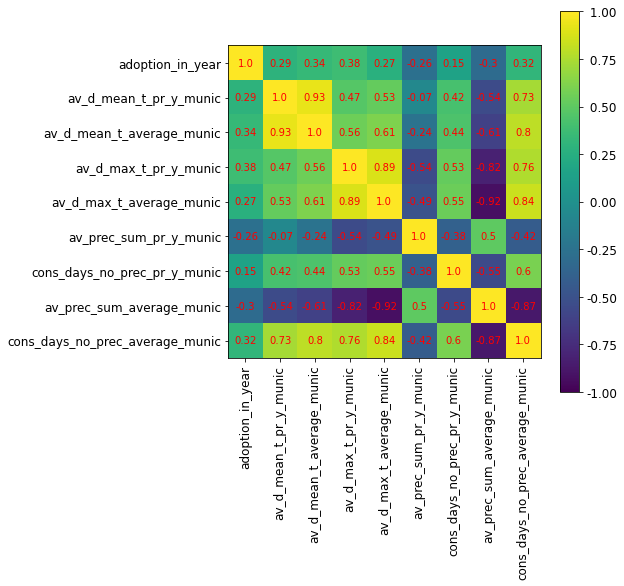

In [359]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + climate_features_kept, label + climate_features_kept], size=(7, 7))

In [360]:
sp_r_both_comb_attr.loc[climate_features_kept].sort_values('spearman r', ascending=False)

,spearman r only PCF,spearman r
av_d_max_t_pr_y_munic,0.208331,0.3781
av_d_mean_t_average_munic,0.0203044,0.341371
cons_days_no_prec_average_munic,-0.0682771,0.319645
av_d_mean_t_pr_y_munic,0.0901362,0.285177
av_d_max_t_average_munic,0.220334,0.26996
cons_days_no_prec_pr_y_munic,0.00537518,0.151505
av_prec_sum_pr_y_munic,0.0630588,-0.263176
av_prec_sum_average_munic,-0.0530865,-0.296921


In [361]:
class TransformClimateFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self, include_av_clim=False, include_y_clim=True):
        self.include_av_clim = include_av_clim
        self.include_y_clim = include_y_clim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        climate_features = X.columns
        
        # Min temp: excluded all since high correlation with av_d_mean_t and low with the target variable
        # Max temp: can keep only one of the two since perfectly correlated, so exluded both days_max_t_over_30
        # Mean temp: excluded days_mean_t_over_20/25 since only one of these kept and av_d_mean_t less correlated with max_t 
        # Prec: exclude days_no (too correlated) and also av_prec if average since too correlated
        
        feats_to_keep = []
        if self.include_av_clim:
            feats_to_keep.extend(['av_d_mean_t_average_munic', 'av_d_max_t_average_munic',
                                  'cons_days_no_prec_average_munic'])
        if self.include_y_clim:
            feats_to_keep.extend(['av_d_mean_t_pr_y_munic', 'av_d_max_t_pr_y_munic',
                                  'av_prec_sum_pr_y_munic', 'cons_days_no_prec_pr_y_munic'])
        
        return X[feats_to_keep]

In [362]:
vif_comb_attr.loc[soil_features]

,VIF
features,
CaCO3_mean_munic,7.468580
CN_mean_munic,18.860842
N_mean_munic,4.307574
P_mean_munic,4.703608
pH_mean_munic,26.368138


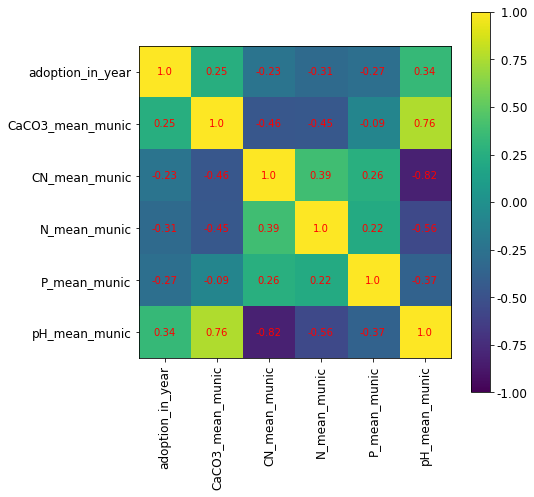

In [363]:
plot_correlation_heatmap(corr_matrix_comb_attr.loc[label + soil_features, label + soil_features], size=(7, 7))

In [364]:
spearman_results_both.loc[soil_features]

,spearman r only PCF,spearman r
CaCO3_mean_munic,0.168306,0.248373
CN_mean_munic,-0.226113,-0.229774
N_mean_munic,-0.181749,-0.310297
P_mean_munic,0.190467,-0.274743
pH_mean_munic,0.364159,0.342957


In [365]:
class TransformSoilFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        soil_features = X.columns

        # 'pH_mean_munic' excluded since high correlation with NC and CaCO3 (also with av_d_mean_t_average_munic)
        
        # Definition of the ones to keep. 
        feats_to_keep = [feat for feat in soil_features if feat != 'pH_mean_munic']

        return X[feats_to_keep]

#### Economic features

In [366]:
class TransformEconomicFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer to reduce and transform the number of classes for each topic in census data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        # Nothing to do, it's just sbp_payments and we pass it
        return X

### Create of a dataset with these transformations

In [367]:
# Get features names
feat_lists = [census_features, adoption_features, climate_features, soil_features, economic_features]
transformers = [TransformCensusFeatures(), TransformAdoptionFeatures(),
                TransformClimateFeatures(), TransformSoilFeatures(),
               TransformEconomicFeatures()]

features_red = []
for f, t in zip(feat_lists, transformers):
    features = t.transform(dataset[f]).columns.to_list()
    features_red = features_red + features

In [368]:
len(features_red)

22

In [369]:
dataset.shape

(2259, 78)

In [370]:
from sklearn.compose import ColumnTransformer

full_dataset_transformation = ColumnTransformer([
    ('census', TransformCensusFeatures(), census_features),
    ('adoption', TransformAdoptionFeatures(), adoption_features),
    ('climate', TransformClimateFeatures(), climate_features),
    ('soil', TransformSoilFeatures(), soil_features),
    ('economic', TransformEconomicFeatures(), economic_features)
],
    remainder='drop')

In [371]:
dataset_comb_attr_red = full_dataset_transformation.fit_transform(dataset)
dataset_comb_attr_red = pd.DataFrame(dataset_comb_attr_red, columns=features_red)
dataset_comb_attr_red.insert(0, 'adoption_in_year', dataset[label].values)

### Reassess VIF

In [372]:
#vif_comb_attr_red = vif(dataset_comb_attr_red.drop('av_d_max_t_average_munic', axis=1))
vif_comb_attr_red = vif(dataset_comb_attr_red)

In [373]:
vif_comb_attr_red.sort_values('VIF', ascending=False)

,VIF
features,
Intercept,770.840950
tot_cumul_adoption_pr_y_port,5.683663
CN_mean_munic,4.648563
tot_cumul_adoption_pr_y_neighbours_adj,4.295660
educ_3rd_cycle_or_higher,4.263003
adoption_pr_y_port,4.133953
pastures_mean_size_munic,4.032767
av_d_max_t_pr_y_munic,3.953802
prof_above_some_long,3.845565


# Outliers

In [374]:
df = dataset_comb_attr_red.copy()

In [375]:
normalized_df=(df-df.min())/(df.max()-df.min())

<AxesSubplot:>

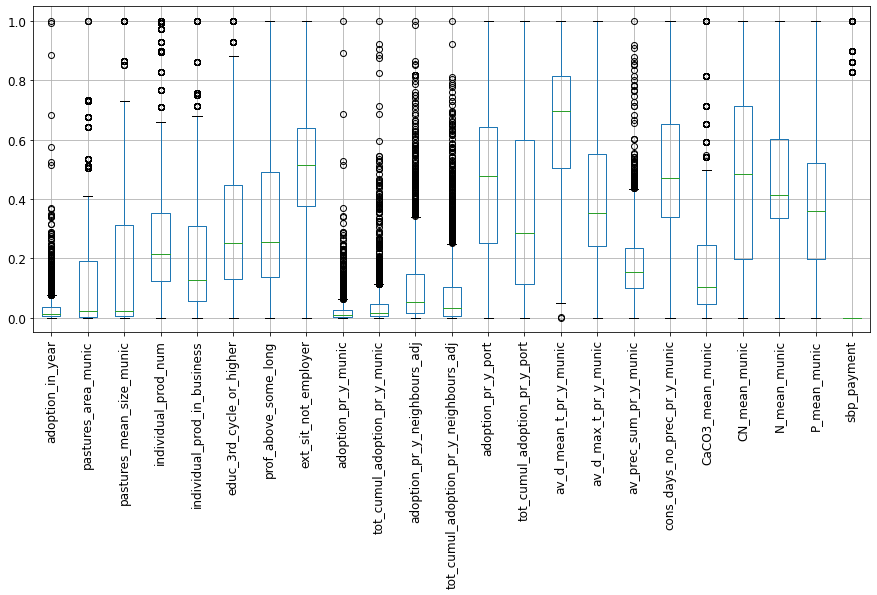

In [376]:
#mpl.rc('xtick', rotation=45, ha="right")
normalized_df.boxplot(figsize=(15, 6), rot=90)

# Check second degree relations

In [377]:
from sklearn.metrics import r2_score
    
def analyse_second_degree_dep(dataset, label, var):
    x = dataset[var]
    y = dataset[label]
    model = np.polyfit(x, y, 2)
    predict = np.poly1d(model)
    print(predict)
    print("R2 score: " + str(r2_score(y, predict(x))))
    idx_pcf = np.where(dataset.index.get_level_values('Year') >= 2009)
    idx_not_pcf = np.where(dataset.index.get_level_values('Year') < 2009)
    _ = plt.scatter(x.iloc[idx_pcf], y.iloc[idx_pcf], s=5, c='red')
    plt.scatter(x.iloc[idx_not_pcf], y.iloc[idx_not_pcf], s=5, c='blue')
    xp = np.linspace(0, 1, 100)
    plt.plot(xp, predict(xp))
    
    plt.ylim(0, 0.25)
    plt.xlim(0, 0.6)
    plt.xlabel(var)
    plt.ylabel(label)

## tot_cumul_adoption_pr_y_munic

<AxesSubplot:xlabel='tot_cumul_adoption_pr_y_munic', ylabel='adoption_in_year'>

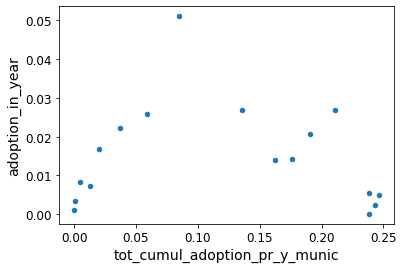

In [378]:
dataset_original.loc['Odemira'].plot(kind='scatter', x='tot_cumul_adoption_pr_y_munic', y='adoption_in_year')

          2
-0.06391 x + 0.1594 x + 0.002143
R2 score: 0.4021807123195005


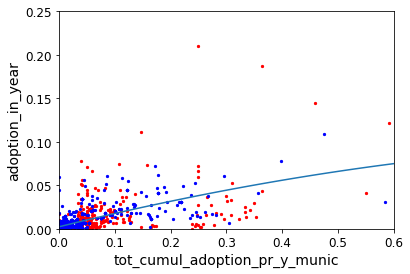

In [379]:
analyse_second_degree_dep(dataset_original, 'adoption_in_year', 'tot_cumul_adoption_pr_y_munic')

### Remove outliers of adoption_in_year

{'whiskers': [<matplotlib.lines.Line2D at 0x1d331f0a248>,
 'caps': [<matplotlib.lines.Line2D at 0x1d331f2b9c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d331f24c48>],
 'medians': [<matplotlib.lines.Line2D at 0x1d331f30f48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d331f30f08>],
 'means': []}

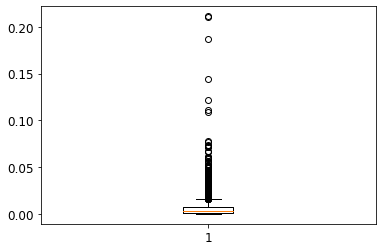

In [380]:
plt.boxplot(dataset['adoption_in_year'])

In [381]:
dataset_original.loc[dataset_original['adoption_in_year'] > 0.1]

adoption_in_year  adoption_pr_y_munic  \
Municipality Year                                          
Abrantes     2010          0.187388             0.052124   
             2012          0.121419             0.040605   
Alcochete    2010          0.210121             0.000000   
             2011          0.144461             0.210121   
             2012          0.211205             0.144461   
Tomar        2005          0.108415             0.077331   
Vila Flor    2009          0.110639             0.018097   

                   tot_cumul_adoption_pr_y_munic  \
Municipality Year                                  
Abrantes     2010                       0.362977   
             2012                       0.590969   
Alcochete    2010                       0.248538   
             2011                       0.458659   
             2012                       0.603120   
Tomar        2005                       0.475360   
Vila Flor    2009                       0.147388   

                   cumul_adoption_10_y_pr_y_munic  \
Municipality Year                                   
Abrantes     2010                        0.231194   
             2012                        0.414225   
Alcochete    2010                        0.215388   
             2011                        0.414216   
             2012                        0.541290   
Tomar        2005                        0.475360   
Vila Flor    2009                        0.140112   

                   adoption_pr_y_neighbours_adj  \
Municipality Year                                 
Abrantes     2010                      0.005481   
             2012                      0.003439   
Alcochete    2010                      0.001089   
             2011                      0.003193   
             2012                      0.012685   
Tomar        2005                      0.005867   
Vila Flor    2009                      0.000000   

                   tot_cumul_adoption_pr_y_neighbours_adj  \
Municipality Year                                           
Abrantes     2010                                0.140848   
             2012                                0.148765   
Alcochete    2010                                0.088122   
             2011                                0.091315   
             2012                                0.104000   
Tomar        2005                                0.095923   
Vila Flor    2009                                0.000000   

                   cumul_adoption_10_y_pr_y_neighbours_adj  \
Municipality Year                                            
Abrantes     2010                                 0.122627   
             2012                                 0.110013   
Alcochete    2010                                 0.076514   
             2011                                 0.075979   
             2012                                 0.082499   
Tomar        2005                                 0.095923   
Vila Flor    2009                                 0.000000   

                   adoption_pr_y_neighbours_10km  \
Municipality Year                                  
Abrantes     2010                       0.006465   
             2012                       0.004243   
Alcochete    2010                       0.000988   
             2011                       0.013120   
             2012                       0.018530   
Tomar        2005                       0.013168   
Vila Flor    2009                       0.000709   

                   tot_cumul_adoption_pr_y_neighbours_10km  \
Municipality Year                                            
Abrantes     2010                                 0.143088   
             2012                                 0.156030   
Alcochete    2010                                 0.101403   
             2011                                 0.114524   
             2012                                 0.133054   
Tomar        2005                                 0.062856 

Only 7 values ovr 0.1 which have a clear separation from the previous ones --> removed

In [382]:
dataset_red = dataset_original.drop(
    dataset_original.loc[dataset_original['adoption_in_year'] > 0.1].index
)
print(len(dataset), len(dataset_red))

2259 2252


         2
-0.2456 x + 0.1808 x + 0.001928
R2 score: 0.405339362976341


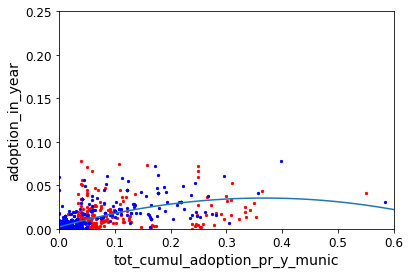

In [383]:
analyse_second_degree_dep(dataset_red, 'adoption_in_year', 'tot_cumul_adoption_pr_y_munic')

### Reassessment of outlies in adoption features after first removal

In [384]:
df = dataset_red[['adoption_in_year', 'adoption_pr_y_munic', 'tot_cumul_adoption_pr_y_munic',
                   'adoption_pr_y_neighbours_adj',
                   'tot_cumul_adoption_pr_y_neighbours_adj', 'adoption_pr_y_port',
                   'tot_cumul_adoption_pr_y_port']]
norm_df_red=(df-df.min())/(df.max()-df.min())

<AxesSubplot:>

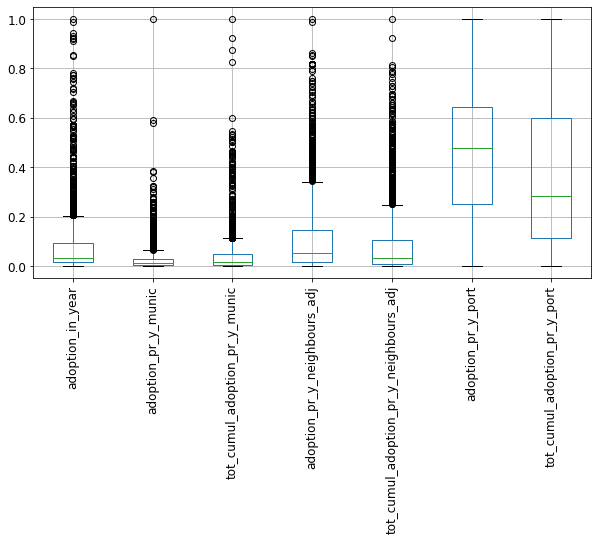

In [385]:
#mpl.rc('xtick', rotation=45, ha="right")
norm_df_red.boxplot(figsize=(10, 5), rot=90)

### Remove outliers of tot_cumul_adoption_pr_y_munic

{'whiskers': [<matplotlib.lines.Line2D at 0x1d3284bc0c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1d32d9a6648>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d3296d6888>],
 'medians': [<matplotlib.lines.Line2D at 0x1d3285ae788>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d326f4bfc8>],
 'means': []}

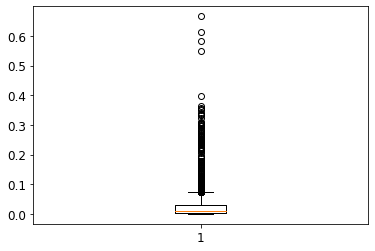

In [386]:
plt.boxplot(dataset_red['tot_cumul_adoption_pr_y_munic'])

In [387]:
dataset_red.loc[dataset_red['tot_cumul_adoption_pr_y_munic'] > 0.39]

adoption_in_year  adoption_pr_y_munic  \
Municipality Year                                          
Abrantes     2011          0.040605             0.187388   
Tomar        2004          0.077331             0.040940   
             2006          0.031084             0.108415   
             2007          0.051554             0.031084   
             2008          0.015921             0.051554   

                   tot_cumul_adoption_pr_y_munic  \
Municipality Year                                  
Abrantes     2011                       0.550364   
Tomar        2004                       0.398029   
             2006                       0.583776   
             2007                       0.614860   
             2008                       0.666414   

                   cumul_adoption_10_y_pr_y_munic  \
Municipality Year                                   
Abrantes     2011                        0.389899   
Tomar        2004                        0.398029   
             2006                        0.583776   
             2007                        0.570887   
             2008                        0.566338   

                   adoption_pr_y_neighbours_adj  \
Municipality Year                                 
Abrantes     2011                      0.004477   
Tomar        2004                      0.000000   
             2006                      0.005280   
             2007                      0.000000   
             2008                      0.014080   

                   tot_cumul_adoption_pr_y_neighbours_adj  \
Municipality Year                                           
Abrantes     2011                                0.145325   
Tomar        2004                                0.090056   
             2006                                0.101203   
             2007                                0.101203   
             2008                                0.115283   

                   cumul_adoption_10_y_pr_y_neighbours_adj  \
Municipality Year                                            
Abrantes     2011                                 0.120890   
Tomar        2004                                 0.090056   
             2006                                 0.101203   
             2007                                 0.078615   
             2008                                 0.080375   

                   adoption_pr_y_neighbours_10km  \
Municipality Year                                  
Abrantes     2011                       0.008699   
Tomar        2004                       0.003564   
             2006                       0.014226   
             2007                       0.007897   
             2008                       0.006504   

                   tot_cumul_adoption_pr_y_neighbours_10km  \
Municipality Year                                            
Abrantes     2011                                 0.151787   
Tomar        2004                                 0.049687   
             2006                                 0.077081   
             2007                                 0.084978   
             2008                                 0.091483   

                   cumul_adoption_10_y_pr_y_neighbours_10km  ...  \
Municipality Year                                            ...   
Abrantes     2011                                  0.124662  ...   
Tomar        2004                                  0.049687  ...   
             2006                                  0.077081  ...   
             2007                                  0.077237  ...   
             2008                                  0.077576  ...   

                   days_min_t_under_0_average_munic  \
Municipality Year                                     
Abrantes     2011                          0.937500   
Tomar        2004                          0.770833   
             2006                          0.770833   
             2007                          0.770833   
             2008                

Only 7 values ovr 0.1 which have a clear separation from the previous ones --> removed

In [388]:
dataset_red_2 = dataset_red.drop(
    dataset_red.loc[dataset_red['tot_cumul_adoption_pr_y_munic'] > 0.39].index
)
print(len(dataset_red), len(dataset_red_2))

2252 2247


         2
-0.5238 x + 0.2384 x + 0.001176
R2 score: 0.4158332392269335


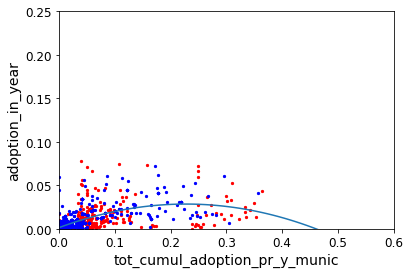

In [389]:
analyse_second_degree_dep(dataset_red_2, 'adoption_in_year', 'tot_cumul_adoption_pr_y_munic')

### Reassessment of outlies in adoption features after first removal

In [390]:
df = dataset_red_2[['adoption_in_year', 'adoption_pr_y_munic', 'tot_cumul_adoption_pr_y_munic',
                   'adoption_pr_y_neighbours_adj',
                   'tot_cumul_adoption_pr_y_neighbours_adj', 'adoption_pr_y_port',
                   'tot_cumul_adoption_pr_y_port']]
norm_df_red_2=(df-df.min())/(df.max()-df.min())

<AxesSubplot:>

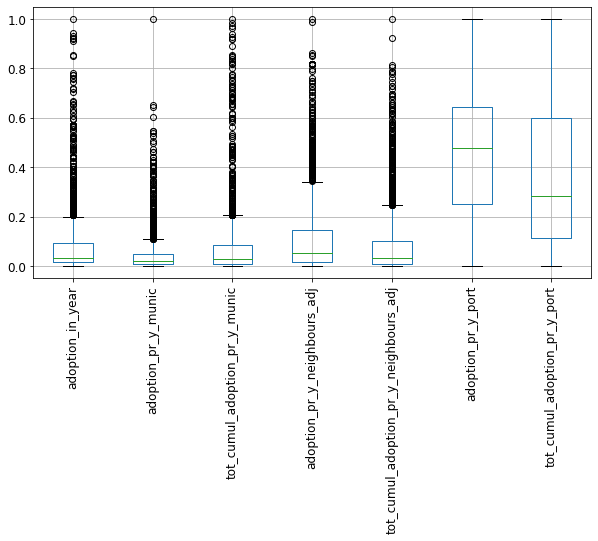

In [391]:
#mpl.rc('xtick', rotation=45, ha="right")
norm_df_red_2.boxplot(figsize=(10, 5), rot=90)

### Remove outliers of adoption_pr_y

{'whiskers': [<matplotlib.lines.Line2D at 0x1d326dce788>,
 'caps': [<matplotlib.lines.Line2D at 0x1d3312bd888>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d3312bde08>],
 'medians': [<matplotlib.lines.Line2D at 0x1d32d940448>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d32e1cbb88>],
 'means': []}

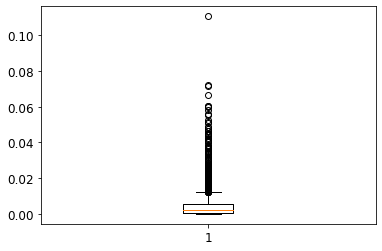

In [392]:
plt.boxplot(dataset_red_2['adoption_pr_y_munic'])

In [393]:
dataset_red_2.loc[dataset_red_2['adoption_pr_y_munic'] > 0.1]

,,adoption_in_year,adoption_pr_y_munic,tot_cumul_adoption_pr_y_munic,cumul_adoption_10_y_pr_y_munic,adoption_pr_y_neighbours_adj,tot_cumul_adoption_pr_y_neighbours_adj,cumul_adoption_10_y_pr_y_neighbours_adj,adoption_pr_y_neighbours_10km,tot_cumul_adoption_pr_y_neighbours_10km,cumul_adoption_10_y_pr_y_neighbours_10km,...,days_min_t_under_0_average_munic,av_prec_sum_average_munic,days_no_prec_average_munic,cons_days_no_prec_average_munic,CaCO3_mean_munic,CN_mean_munic,N_mean_munic,P_mean_munic,pH_mean_munic,sbp_payment
Municipality,Year,,,,,,,,,,,,,,,,,,,,,
Vila Flor,2010,0.005879,0.110639,0.258027,0.244221,0.0,0.0,0.0,0.004334,0.010107,0.009567,...,25.041667,554.687485,287.958333,57.604167,24.247688,12.155631,1.396075,17.962678,5.918117,132.1


Only 7 values ovr 0.1 which have a clear separation from the previous ones --> removed

In [394]:
dataset_red_3 = dataset_red_2.drop(
    dataset_red_2.loc[dataset_red_2['adoption_pr_y_munic'] > 0.1].index
)
print(len(dataset_red_2), len(dataset_red_3))

2247 2246


         2
-0.5202 x + 0.2384 x + 0.001172
R2 score: 0.41814514964106286


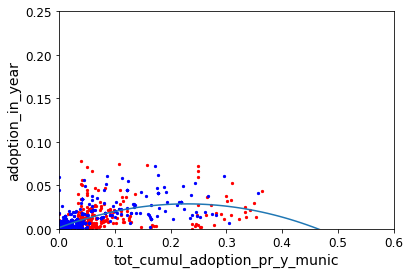

In [395]:
analyse_second_degree_dep(dataset_red_3, 'adoption_in_year', 'tot_cumul_adoption_pr_y_munic')

### Reassessment of outlies in adoption features after first removal

In [396]:
df = dataset_red_3[['adoption_in_year', 'adoption_pr_y_munic', 'tot_cumul_adoption_pr_y_munic',
                   'adoption_pr_y_neighbours_adj',
                   'tot_cumul_adoption_pr_y_neighbours_adj', 'adoption_pr_y_port',
                   'tot_cumul_adoption_pr_y_port']]
norm_df_red_3=(df-df.min())/(df.max()-df.min())

<AxesSubplot:>

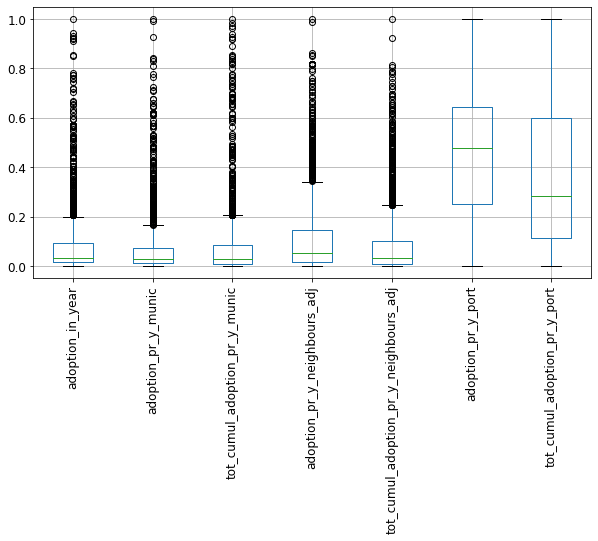

In [397]:
#mpl.rc('xtick', rotation=45, ha="right")
norm_df_red_3.boxplot(figsize=(10, 5), rot=90)

In [398]:
d = pd.DataFrame(index=features_red)

In [399]:
d['VIF'] = vif_comb_attr_red

In [400]:
dataset_comb_attr_red_PCF = pd.DataFrame(dataset_comb_attr_red.values, index=dataset_original.index,
                                        columns=dataset_comb_attr_red.columns).loc[(slice(None), [2009, 2010, 2011, 2012]), :]

In [401]:
d2 = get_spearman_both(features_red, dataset_comb_attr_red, dataset_comb_attr_red_PCF)

In [402]:
d3 = pd.concat([d2, d], axis=1)

In [403]:
d3

,spearman r only PCF,spearman r,VIF
pastures_area_munic,-0.261476,0.145605,2.315153
pastures_mean_size_munic,0.189144,0.205555,4.032767
individual_prod_num,-0.152782,-0.0815092,1.441564
individual_prod_in_business,0.268933,0.215118,3.090068
educ_3rd_cycle_or_higher,0.451308,0.283652,4.263003
prof_above_some_long,0.312367,0.153014,3.845565
ext_sit_not_employer,0.11831,0.240694,2.000644
adoption_pr_y_munic,0.381715,0.678448,2.232535
tot_cumul_adoption_pr_y_munic,0.357728,0.701711,2.756189
adoption_pr_y_neighbours_adj,0.146259,0.550649,2.739223
